## SHAP, LRP & attention scores with Attention-LSTM
Author: Lin Lee Cheong <br>
Date created: 1/13/2021 <br>
Date updated: 1/26/2021 <br>

**Data:** <br>
Using the final version of 30 sequence length dataset generated by Tes<br>
First set of data out of the 10 sets 
Train, validation (for model training), test (for performance etc), and example (4 output)
<br>


**Steps:** <br>
1. Read in datasets [DONE]
2. LSTM model training 
    - TODO: check probab outputs
    - save epoch train, val, loss, etc [DONE]
    - calculated SHAP & relevance scores for val_set of 64 [DONE]
    - calculate rbo, tau for val_set of 64 [DONE]
    - plot rbo, tau
3. Extract SHAP, attention and relevance scores for a TEST set of 64
    - calculate SHAP, relevance scores, performance (AUC, test loss)
    - calculate rbo, tau
3. Extract SHAP and relevance scores for example set of 4
    - plot epoch evolution [DONE]
    - add attention
4. Save output in dict format

In [1]:
import sys

sys.path.append("../")

import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import numpy as np
from numpy import newaxis as na

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *
from lrp_att_model import *
import shap_jacc_utils as sj_utils
from scipy import stats

import rbo

In [2]:
def get_wtau(x, y):
    return stats.weightedtau(x, y, rank=None)[0]

def get_rbo(x, y, uid, p=0.7):
    x_idx = np.argsort(x)[::-1]
    y_idx = np.argsort(y)[::-1]

    return rbo.RankingSimilarity(
        [uid[idx] for idx in x_idx], 
        [uid[idx] for idx in y_idx]).rbo(p=p)

# calculate ground truth scores
def is_value(x):
    if '_N' in x:
        return False
    return True

In [3]:
nrows = 1e9
test_nrows = 50
min_freq = 1
batch_size = 64

seq_len = 30

train_data_path = "../../../data/toy_dataset/data/final_event_30_1/train.csv"
valid_data_path = "../../../data/toy_dataset/data/final_event_30_1/val.csv"
test_data_path = "../../../data/toy_dataset/data/final_event_30_1/test.csv"
vocab_path = "../../../data/toy_dataset/data/final_event_30/vocabs/vocab_30.pkl"
lstm_model_save_path = "./model_weights/lstm_att_model_nobias_lchw_30_evol_right_dim_l"
output_save_dir = "./outputs_lstm_att_model_nobias_lchw_30_evol_right_dim_l/"

embedding_dim = 5
hidden_dim = 5
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

In [4]:
# Output results directory creation, as needed
for fp in [output_save_dir]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f"New directory created: {fp}")
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [5]:
# create the example set
temp_data_path = './temp_test.csv'
test_df = pd.read_csv(test_data_path)
patients = ['0XV60KZ3BF', 'OJI80KW377', 'R6EJJFP6XR', 'WFRQDJ5Q60']
test_df[test_df.patient_id.isin(
    patients)].to_csv(temp_data_path, index=False)

## 1. Define and create Dataloaders

In [6]:
with open(vocab_path, "rb") as fp:
    vocab = pickle.load(fp)
print(f"vocab len: {len(vocab)}")  # 30 vocab + padding + unknown

vocab len: 32


In [7]:
train_dataset, _ = build_lstm_dataset(
    train_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

valid_dataset, _ = build_lstm_dataset(
    valid_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

test_dataset, _ = build_lstm_dataset(
    test_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=test_nrows,
    rev=rev,
)

example_dataset, _ = build_lstm_dataset(
    temp_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

Building dataset from ../../../data/toy_dataset/data/final_event_30_1/train.csv..
Success!
Building dataset from ../../../data/toy_dataset/data/final_event_30_1/val.csv..
Success!
Building dataset from ../../../data/toy_dataset/data/final_event_30_1/test.csv..
Success!
Building dataset from ./temp_test.csv..
Success!


In [8]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

example_dataloader = DataLoader(
    example_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

## LSTM Model Training

### 2a. Define and load model

In [9]:
import numpy as np
import torch
import torch.nn as nn
from lstm_models import SimpleLSTM


class AttNoHtLSTM(SimpleLSTM):
    def __init__(
        self,
        emb_dim,
        hidden_dim,
        vocab,
        device,
        nlayers=1,
        bidi=True,
        use_gpu=True,
        pad_idx=0,
        dropout=None,
        init_type="zero",
        linear_bias=True,
    ):
        super(AttNoHtLSTM, self).__init__(
            emb_dim=emb_dim, hidden_dim=hidden_dim, vocab=vocab, device=device
        )

        self.device = device
        self.use_gpu = use_gpu

        self.emb_dim = emb_dim
        self.input_dim = len(vocab)
        self.vocab = vocab
        self.pad_idx = pad_idx
        self.emb_layer = nn.Embedding(self.input_dim, emb_dim, padding_idx=pad_idx)

        self.hidden_dim = hidden_dim
        self.bidi = bidi
        self.nlayers = nlayers
        self.linear_bias = linear_bias

        """
        self.attn_layer = (
            nn.Linear(hidden_dim *2, 1, bias=linear_bias) 
            if bidi else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )
        """
        if dropout is None:
            self.lstm = nn.LSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                num_layers=nlayers,
                bidirectional=bidi,
                batch_first=True,
            )
        else:
            self.lstm = nn.LSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                num_layers=nlayers,
                bidirectional=bidi,
                batch_first=True,
                dropout=dropout,
            )

        self.pred_layer = (
            nn.Linear(hidden_dim * 2, 1, bias=linear_bias)
            if bidi
            else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )

        self.dpt = nn.Dropout(dropout)

        """
        self.context_layer = (
            nn.Linear(hidden_dim * 2, 1, bias=linear_bias) 
            if bidi else nn.Linear(hidden_dim, 1, bias=linear_bias)
        )
        """
        self.init_weights()

    def forward(self, tokens, ret_attn=False):

        if self.dpt is not None:
            embedded = self.dpt(self.emb_layer(tokens))
        else:
            embedded = self.emb_layer(tokens)

        if self.init_type == "learned":
            self.h0.requires_grad = True
            self.c0.requires_grad = True
            hidden = (
                self.h0.repeat(1, tokens.shape[0], 1),
                self.c0.repeat(1, tokens.shape[0], 1),
            )

        else:  # default behavior
            hidden = self.init_hidden(tokens.shape[0])
            hidden = self.repackage_hidden(hidden)

        text_lengths = torch.sum(tokens != self.pad_idx, dim=1).to("cpu")

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, enforce_sorted=False, batch_first=True
        )

        packed_output, (final_hidden, cell) = self.lstm(packed_embedded, hidden)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True, total_length=tokens.shape[1]
        )

        if self.bidi:
            out = torch.cat(
                [output[:, -1, : self.hidden_dim], output[:, 0, self.hidden_dim :]],
                dim=1,
            )
        else:
            out = output[:, -1, :]

        # Switch to multiplicative attention
        mask_feats = np.array(tokens.cpu().numpy() == 0)
        mask_feats = -1000 * mask_feats.astype(np.int)

        mask_feats = torch.Tensor(mask_feats).to(self.device)

        # 1/6: reverse order of output
        # rev_idx = [idx for idx in range(output.shape[1]-1, -1, -1)]
        # import IPython
        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()
        # output = torch.cat(
        #    (output[:, :, :self.hidden_dim],
        #    output[:, rev_idx, self.hidden_dim:]),
        #    dim=-1
        # )

        attn_weights_int = torch.bmm(output, out.unsqueeze(2)).squeeze(2) / (
            (tokens.shape[1]) ** 0.5
        )
        attn_weights = nn.functional.softmax(attn_weights_int + mask_feats, -1)

        context = torch.bmm(output.transpose(1, 2), attn_weights.unsqueeze(-1)).squeeze(
            -1
        )

        # attention = self.context_layer(output).squeeze(-1)
        # att_weights = nn.functional.softmax(attention + mask_feats, dim=-1)
        # context = torch.bmm(att_weights.unsqueeze(1), output).squeeze(1)
        # import IPython.core.debugger

        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()
        # concat_out = torch.cat((context, out), dim=1)
        concat_out = context

        if self.dpt is not None:
            pred = self.pred_layer(self.dpt(concat_out))
        else:
            pred = self.pred_layer(concat_out)

        if ret_attn:
            return (
                pred.detach().cpu().numpy(),
                attn_weights.detach().cpu().numpy(),
                context.detach().cpu().numpy(),
                attn_weights_int.detach().cpu().numpy(),
                out.detach().cpu().numpy(),
                output.detach().cpu().numpy(),
            )

        return pred

    def forward_shap(self, token_ids, mask, full_id_matrix=False):
        token_ids = token_ids if token_ids.is_cuda else token_ids.cuda()

        if self.init_type == "learned":
            self.h0.requires_grad = False
            self.c0.requires_grad = False

            hidden = (self.h0.repeat(1, 1, 1), self.c0.repeat(1, 1, 1))

        else:  # default behavior
            hidden = self.init_hidden(1)
            hidden = self.repackage_hidden(hidden)

        token_ids[sum(mask) :, :] = 0
        embedded = torch.matmul(token_ids, self.emb_layer.weight).unsqueeze(0)

        embedded = embedded[:, : sum(mask), :]

        output, _ = self.lstm(embedded, hidden)

        # output = output.permute(1, 0, 2)  # [batch, text_length, hidden_dim]
        # print(f'Output dimensions: {output.shape}')
        if self.bidi:
            out = torch.cat(
                [output[:, -1, : self.hidden_dim], output[:, 0, self.hidden_dim :]],
                dim=1,
            )
        else:
            out = output[:, -1, :]
        # import IPython.core.debugger

        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()

        # print(f'Stacked hidden dimensions: {stacked_hidden.shape}')
        # print(f'mask weight dimensions: {mask_feats.shape}')
        # attention = self.context_layer(output).squeeze(-1)
        # att_weights = nn.functional.softmax(attention, dim=-1)
        # context = torch.bmm(att_weights.unsqueeze(1), output).squeeze(1)
        attn_weights = torch.bmm(output, out.unsqueeze(2)).squeeze(2) / (
            sum(mask) ** 0.5
        )

        soft_attn_weights = nn.functional.softmax(attn_weights, 1)

        context = torch.bmm(
            output.transpose(1, 2), soft_attn_weights.unsqueeze(-1)
        ).squeeze(-1)

        # concat_out = torch.cat((context, out), dim=1)
        concat_out = context
        pred = self.pred_layer(concat_out)

        return pred

### 2b. Define and load LRP LSTM model

In [10]:
def lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor=0.0, debug=False):
    """
    LRP for a linear layer with input dim D and output dim M.
    Args:
    - hin:            forward pass input, of shape (D,)
    - w:              connection weights, of shape (D, M)
    - b:              biases, of shape (M,)
    - hout:           forward pass output, of shape (M,) (unequal to np.dot(w.T,hin)+b if more than one incoming layer!)
    - Rout:           relevance at layer output, of shape (M,)
    - bias_nb_units:  total number of connected lower-layer units (onto which the bias/stabilizer contribution is redistributed for sanity check)
    - eps:            stabilizer (small positive number)
    - bias_factor:    set to 1.0 to check global relevance conservation, otherwise use 0.0 to ignore bias/stabilizer redistribution (recommended)
    Returns:
    - Rin:            relevance at layer input, of shape (D,)
    """
    sign_out = np.where(hout[na, :] >= 0, 1.0, -1.0)  # shape (1, M)

    # numer    = (w * hin[:,na]) + ( (bias_factor*b[na,:]*1.) * 1./bias_nb_units )
    numer = (w * hin[:, na]) + (
        bias_factor * (b[na, :] * 1.0 + eps * sign_out * 1.0) / bias_nb_units
    )  # shape (D, M)

    # Note: here we multiply the bias_factor with both the bias b and the stabilizer eps since in fact
    # using the term (b[na,:]*1. + eps*sign_out*1.) / bias_nb_units in the numerator is only useful for sanity check
    # (in the initial paper version we were using (bias_factor*b[na,:]*1. + eps*sign_out*1.) / bias_nb_units instead)

    denom = hout[na, :] + (eps * sign_out * 1.0)  # shape (1, M)

    message = (numer / denom) * Rout[na, :]  # shape (D, M)

    Rin = message.sum(axis=1)  # shape (D,)

    if debug:
        print("local diff: ", Rout.sum() - Rin.sum())
    # Note:
    # - local  layer   relevance conservation
    #   if bias_factor==1.0 and bias_nb_units==D (i.e. when only one incoming layer)
    # - global network relevance conservation
    #   if bias_factor==1.0 and bias_nb_units set accordingly to the total number of lower-layer connections
    # -> can be used for sanity check

    return Rin

In [11]:
class LSTM_LRP_MultiLayer:
    def __init__(self, pymodel):
        super(LSTM_LRP_MultiLayer, self).__init__()

        self.init_model(pymodel)

    def init_model(self, pymodel):

        self.device = pymodel.device
        self.use_gpu = pymodel.use_gpu
        self.bidi = pymodel.bidi

        self.emb_dim = pymodel.emb_dim
        self.vocab = pymodel.vocab
        self.input_dim = len(self.vocab)
        self.pad_idx = pymodel.pad_idx
        self.hidden_dim = pymodel.hidden_dim

        self.emb = pymodel.emb_layer.weight.detach().numpy()

        param_list = list(pymodel.lstm.named_parameters())
        param_dict = {}
        for param_tuple in param_list:
            param_dict[param_tuple[0]] = param_tuple[-1].detach().numpy()

        # rearrange, pytorch uses ifgo format, need to move to icfo/igfo format
        idx_list = (
            list(range(0, self.hidden_dim))
            + list(range(self.hidden_dim * 2, self.hidden_dim * 3))
            + list(range(self.hidden_dim, self.hidden_dim * 2))
            + list(range(self.hidden_dim * 3, self.hidden_dim * 4))
        )
        self.nlayers = pymodel.nlayers

        # i (input), g (candidate), f (forget), o (output) order
        # (4 * hidden_dim, emb_dim)
        self.Wxh_Left = {}
        self.bxh_Left = {}
        self.Whh_Left = {}
        self.bhh_Left = {}

        if self.bidi:
            self.Wxh_Right = {}
            self.bxh_Right = {}
            self.Whh_Right = {}
            self.bhh_Right = {}

        for layer in range(nlayers):
            self.Wxh_Left[layer] = param_dict[f"weight_ih_l{layer}"][idx_list]
            self.bxh_Left[layer] = param_dict[f"bias_ih_l{layer}"][idx_list]  # shape 4d
            self.Whh_Left[layer] = param_dict[f"weight_hh_l{layer}"][
                idx_list
            ]  # shape 4d*d
            self.bhh_Left[layer] = param_dict[f"bias_hh_l{layer}"][idx_list]  # shape 4d

            if self.bidi:
                # LSTM right encoder
                self.Wxh_Right[layer] = param_dict[f"weight_ih_l{layer}_reverse"][
                    idx_list
                ]
                self.bxh_Right[layer] = param_dict[f"bias_ih_l{layer}_reverse"][
                    idx_list
                ]
                self.Whh_Right[layer] = param_dict[f"weight_hh_l{layer}_reverse"][
                    idx_list
                ]
                self.bhh_Right[layer] = param_dict[f"bias_hh_l{layer}_reverse"][
                    idx_list
                ]

        # START ADDED: CONTEXT LAYER INIT
        # linear output layer: shape C * 4d
        # 0-d: fwd & context
        # d-2d: rev & context
        # 2d-3d: fwd & final hidden
        # 3d-4d: rev & final hidden
        Why = pymodel.pred_layer.weight.detach().numpy()

        self.Why_Left = Why[:, 2 * self.hidden_dim : 3 * self.hidden_dim]  # shape C*d

        if self.bidi:
            self.Why_Right = Why[:, 3 * self.hidden_dim :]  # shape C*d

        self.Wcy_Left = Why[:, : self.hidden_dim]

        if self.bidi:
            self.Wcy_Right = Why[:, self.hidden_dim : 2 * self.hidden_dim]
        # END ADDED: CONTEXT LAYER INIT

    def set_input(self, tokens):
        T = len(tokens)  # sequence length
        d = int(self.Wxh_Left[0].shape[0] / 4)  # hidden layer dimension
        e = self.emb.shape[1]  # word embedding dimension

        self.w = tokens
        self.x = {}
        self.x_rev = {}
        x = np.zeros((T, e))
        x[:, :] = self.emb[tokens, :]
        self.x[0] = x
        self.x_rev[0] = x[::-1, :].copy()
        self.h_Left = {}
        self.c_Left = {}

        if self.bidi:
            self.h_Right = {}
            self.c_Right = {}

        for layer in range(self.nlayers):
            self.h_Left[layer] = np.zeros((T + 1, d))
            self.c_Left[layer] = np.zeros((T + 1, d))

            if self.bidi:
                self.h_Right[layer] = np.zeros((T + 1, d))
                self.c_Right[layer] = np.zeros((T + 1, d))

        self.att_score = None

    def forward_gate(self, layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir):

        if gate_dir == "left":
            self.gates_xh_Left[layer][t] = np.dot(
                self.Wxh_Left[layer], self.x[layer][t]
            )
            self.gates_hh_Left[layer][t] = np.dot(
                self.Whh_Left[layer], self.h_Left[layer][t - 1]
            )
            self.gates_pre_Left[layer][t] = (
                self.gates_xh_Left[layer][t]
                + self.gates_hh_Left[layer][t]
                + self.bxh_Left[layer]
                + self.bhh_Left[layer]
            )
            self.gates_Left[layer][t, idx] = 1.0 / (
                1.0 + np.exp(-self.gates_pre_Left[layer][t, idx])
            )
            self.gates_Left[layer][t, idx_g] = np.tanh(
                self.gates_pre_Left[layer][t, idx_g]
            )
            self.c_Left[layer][t] = (
                self.gates_Left[layer][t, idx_f] * self.c_Left[layer][t - 1]
                + self.gates_Left[layer][t, idx_i] * self.gates_Left[layer][t, idx_g]
            )
            self.h_Left[layer][t] = self.gates_Left[layer][t, idx_o] * np.tanh(
                self.c_Left[layer][t]
            )

        if gate_dir == "right":
            self.gates_xh_Right[layer][t] = np.dot(
                self.Wxh_Right[layer], self.x_rev[layer][t]
            )
            self.gates_hh_Right[layer][t] = np.dot(
                self.Whh_Right[layer], self.h_Right[layer][t - 1]
            )
            self.gates_pre_Right[layer][t] = (
                self.gates_xh_Right[layer][t]
                + self.gates_hh_Right[layer][t]
                + self.bxh_Right[layer]
                + self.bhh_Right[layer]
            )
            self.gates_Right[layer][t, idx] = 1.0 / (
                1.0 + np.exp(-self.gates_pre_Right[layer][t, idx])
            )
            self.gates_Right[layer][t, idx_g] = np.tanh(
                self.gates_pre_Right[layer][t, idx_g]
            )
            self.c_Right[layer][t] = (
                self.gates_Right[layer][t, idx_f] * self.c_Right[layer][t - 1]
                + self.gates_Right[layer][t, idx_i] * self.gates_Right[layer][t, idx_g]
            )
            self.h_Right[layer][t] = self.gates_Right[layer][t, idx_o] * np.tanh(
                self.c_Right[layer][t]
            )

    def forward_lrp(self):
        """
        Standard forward pass.
        Compute the hidden layer values (assuming input x/x_rev was previously set)
        """
        T = len(self.w)
        d = int(self.Wxh_Left[0].shape[0] / 4)

        # gate indices (assuming the gate ordering in the LSTM weights is i,g,f,o):
        idx = np.hstack((np.arange(0, d), np.arange(2 * d, 4 * d))).astype(
            int
        )  # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = (
            np.arange(0, d),
            np.arange(d, 2 * d),
            np.arange(2 * d, 3 * d),
            np.arange(3 * d, 4 * d),
        )  # indices of gates i,g,f,o separately

        # initialize
        self.gates_xh_Left = {}
        self.gates_hh_Left = {}
        self.gates_pre_Left = {}
        self.gates_Left = {}

        if self.bidi:
            self.gates_xh_Right = {}
            self.gates_hh_Right = {}
            self.gates_pre_Right = {}
            self.gates_Right = {}

        for layer in range(self.nlayers):
            self.gates_xh_Left[layer] = np.zeros((T, 4 * d))
            self.gates_hh_Left[layer] = np.zeros((T, 4 * d))
            self.gates_pre_Left[layer] = np.zeros((T, 4 * d))  # gates pre-activation
            self.gates_Left[layer] = np.zeros((T, 4 * d))  # gates activation

            if self.bidi:
                self.gates_xh_Right[layer] = np.zeros((T, 4 * d))
                self.gates_hh_Right[layer] = np.zeros((T, 4 * d))
                self.gates_pre_Right[layer] = np.zeros((T, 4 * d))
                self.gates_Right[layer] = np.zeros((T, 4 * d))

        # START ADDED: INITIALIZE CONTEXT LAYERS
        self.ctxt_Left = np.zeros((1, d))
        self.ctxt_Right = np.zeros((1, d))
        self.att_wgt_Left = np.zeros((T, 1))
        self.att_wgt_Right = np.zeros((T, 1))
        self.att_score = np.zeros((T, 1))

        # END ADDED: INITIALIZE CONTEXT LAYERS

        # START EDIT: cycle through first layer first
        layer = 0
        for t in range(T):
            self.forward_gate(
                layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="left"
            )
            if self.bidi:
                self.forward_gate(
                    layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="right"
                )

        # go through all the rest of the layers
        if self.nlayers > 1:
            ## TODO: fix init t-1 (zero time step) Zeroes!!
            self.x[layer + 1] = (
                np.concatenate(
                    (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
                )
                if self.bidi
                else self.h_Left[layer][:T]
            )

            self.x_rev[layer + 1] = self.x[layer + 1][::-1].copy()

            for layer in range(1, self.nlayers):
                for t in range(T):
                    self.forward_gate(
                        layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="left"
                    )
                    if self.bidi:
                        self.forward_gate(
                            layer, t, idx, idx_i, idx_g, idx_f, idx_o, gate_dir="right"
                        )

                    self.x[layer + 1] = np.concatenate(
                        (self.h_Left[layer][:T], self.h_Right[layer][:T][::-1]), axis=1
                    )
                    self.x_rev[layer + 1] = self.x[layer + 1][::-1].copy()

        # calculate attention layer & context layer
        top_layer = self.nlayers - 1
        self.att_wgt_Left = np.dot(
            self.h_Left[top_layer][:T, :], self.h_Left[top_layer][T - 1]
        )
        self.att_wgt_Right = np.dot(
            self.h_Right[top_layer][:T, :], self.h_Right[top_layer][T - 1]
        )
        self.att_score = self.stable_softmax(
            (self.att_wgt_Left + self.att_wgt_Right) / (T ** 0.5)
        )

        self.ctxt_Left = (self.att_score[:, na] * self.h_Left[top_layer][:T]).sum(
            axis=0
        )
        self.ctxt_Right = (self.att_score[:, na] * self.h_Right[top_layer][:T]).sum(
            axis=0
        )

        # CALCULATE WITH CONTEXT & OUT, NOT JUST HIDDEN
        # self.y_Left = np.dot(self.Why_Left, self.h_Left[top_layer][T - 1])
        self.y_Left = np.dot(self.Wcy_Left, self.ctxt_Left)

        # self.y_Right = np.dot(self.Why_Right, self.h_Right[top_layer][T - 1])
        self.y_Right = np.dot(self.Wcy_Right, self.ctxt_Right)

        self.s = self.y_Left + self.y_Right

        return self.s.copy()  # prediction scores

    def stable_softmax(self, x):
        z = x - np.max(x)
        num = np.exp(z)
        denom = np.sum(num)
        softmax_vals = num / denom

        return softmax_vals

    def lrp_left_gate(
        self,
        Rc_Left,
        Rh_Left,
        Rg_Left,
        Rx,
        layer,
        t,
        d,
        ee,
        idx,
        idx_f,
        idx_i,
        idx_g,
        idx_o,
        eps,
        bias_factor,
    ):

        # import IPython
        # dbg = IPython.core.debugger.Pdb()
        # dbg.set_trace()

        Rc_Left[layer][t] += Rh_Left[layer][t]
        Rc_Left[layer][t - 1] += lrp_linear(
            self.gates_Left[layer][t, idx_f] * self.c_Left[layer][t - 1],
            np.identity(d),
            np.zeros((d)),
            self.c_Left[layer][t],
            Rc_Left[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rg_Left[layer][t] += lrp_linear(
            self.gates_Left[layer][t, idx_i] * self.gates_Left[layer][t, idx_g],
            np.identity(d),
            np.zeros((d)),
            self.c_Left[layer][t],
            Rc_Left[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rx[layer][t] += lrp_linear(
            self.x[layer][t],
            self.Wxh_Left[layer][idx_g].T,
            self.bxh_Left[layer][idx_g] + self.bhh_Left[layer][idx_g],
            self.gates_pre_Left[layer][t, idx_g],
            Rg_Left[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )

        Rh_Left[layer][t - 1] += lrp_linear(
            self.h_Left[layer][t - 1],
            self.Whh_Left[layer][idx_g].T,
            self.bxh_Left[layer][idx_g] + self.bhh_Left[layer][idx_g],
            self.gates_pre_Left[layer][t, idx_g],
            Rg_Left[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )
        return Rc_Left, Rh_Left, Rg_Left, Rx

    def lrp_right_gate(
        self,
        Rc_Right,
        Rh_Right,
        Rg_Right,
        Rx_rev,
        layer,
        t,
        d,
        ee,
        idx,
        idx_f,
        idx_i,
        idx_g,
        idx_o,
        eps,
        bias_factor,
    ):
        Rc_Right[layer][t] += Rh_Right[layer][t]
        Rc_Right[layer][t - 1] += lrp_linear(
            self.gates_Right[layer][t, idx_f] * self.c_Right[layer][t - 1],
            np.identity(d),
            np.zeros((d)),
            self.c_Right[layer][t],
            Rc_Right[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )
        Rg_Right[layer][t] += lrp_linear(
            self.gates_Right[layer][t, idx_i] * self.gates_Right[layer][t, idx_g],
            np.identity(d),
            np.zeros((d)),
            self.c_Right[layer][t],
            Rc_Right[layer][t],
            2 * d,
            eps,
            bias_factor,
            debug=False,
        )

        Rx_rev[layer][t] += lrp_linear(
            self.x_rev[layer][t],
            self.Wxh_Right[layer][idx_g].T,
            self.bxh_Right[layer][idx_g] + self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t, idx_g],
            Rg_Right[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )

        Rh_Right[layer][t - 1] += lrp_linear(
            self.h_Right[layer][t - 1],
            self.Whh_Right[layer][idx_g].T,
            self.bxh_Right[layer][idx_g] + self.bhh_Right[layer][idx_g],
            self.gates_pre_Right[layer][t, idx_g],
            Rg_Right[layer][t],
            d + ee,
            eps,
            bias_factor,
            debug=False,
        )
        return Rc_Right, Rh_Right, Rg_Right, Rx_rev

    def lrp(self, w, LRP_class, eps=0.001, bias_factor=0.0):
        """
        Layer-wise Relevance Propagation (LRP) backward pass.
        Compute the hidden layer relevances by performing LRP for the target class LRP_class
        (according to the papers:
            - https://doi.org/10.1371/journal.pone.0130140
            - https://doi.org/10.18653/v1/W17-5221 )
        """
        # forward pass
        self.set_input(w)
        self.forward_lrp()

        T = len(self.w)
        d = int(self.Wxh_Left[0].shape[0] / 4)
        e = self.emb.shape[1]
        C = self.Why_Left.shape[0]  # number of classes
        idx = np.hstack((np.arange(0, d), np.arange(2 * d, 4 * d))).astype(
            int
        )  # indices of gates i,f,o together
        idx_i, idx_g, idx_f, idx_o = (
            np.arange(0, d),
            np.arange(d, 2 * d),
            np.arange(2 * d, 3 * d),
            np.arange(3 * d, 4 * d),
        )  # indices of gates i,g,f,o separately

        # initialize
        Rx = {}
        Rx_rev = {}
        Rx_all = {}

        Rh_Left = {}
        Rc_Left = {}
        Rg_Left = {}  # gate g only

        if self.bidi:
            Rh_Right = {}
            Rc_Right = {}
            Rg_Right = {}  # gate g only

        for layer in range(self.nlayers):
            Rx[layer] = np.zeros(self.x[layer].shape)
            Rx_rev[layer] = np.zeros(self.x[layer].shape)
            Rx_all[layer] = np.zeros(self.x[layer].shape)

            Rh_Left[layer] = np.zeros((T + 1, d))
            Rc_Left[layer] = np.zeros((T + 1, d))
            Rg_Left[layer] = np.zeros((T, d))  # gate g only

            if self.bidi:
                Rh_Right[layer] = np.zeros((T + 1, d))
                Rc_Right[layer] = np.zeros((T + 1, d))
                Rg_Right[layer] = np.zeros((T, d))  # gate g only

        Rctxt_Left = np.zeros((1, d))
        Rctxt_Right = np.zeros((1, d))

        Rout_mask = np.zeros((C))
        Rout_mask[LRP_class] = 1.0

        # process top most layer first
        # format reminder: lrp_linear(hin, w, b, hout, Rout, bias_nb_units, eps, bias_factor)
        layer = self.nlayers - 1
        """
        Rh_Left[layer][T - 1] = lrp_linear(
            self.h_Left[layer][T - 1],
            self.Why_Left.T,  # 8d
            np.zeros((C)),
            self.s,
            self.s * Rout_mask,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rh_Right[layer][T - 1] = lrp_linear(
                self.h_Right[layer][T - 1],
                self.Why_Right.T,  # 8d
                np.zeros((C)),
                self.s,
                self.s * Rout_mask,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )
        """
        # ADD CONTEXT CALCULATIONS TO CONTEXT LAYER
        Rctxt_Left = lrp_linear(
            self.ctxt_Left,
            self.Wcy_Left.T,  # 8d
            np.zeros((C)),
            self.s,
            self.s * Rout_mask,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rctxt_Right = lrp_linear(
                self.ctxt_Right,
                self.Wcy_Right.T,  # 8d
                np.zeros((C)),
                self.s,
                self.s * Rout_mask,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

        # CONTRIBUTION FROM ATTN LAYER
        Rh_Left[layer][T - 1] += lrp_linear(
            self.h_Left[layer][T - 1],
            np.identity((d)),
            np.zeros((d)),
            self.ctxt_Left,
            self.att_score[T - 1] * Rctxt_Left,
            4 * d,
            eps,
            bias_factor,
            debug=False,
        )
        if self.bidi:
            Rh_Right[layer][T - 1] += lrp_linear(
                self.h_Right[layer][T - 1],
                np.identity((d)),
                np.zeros((d)),
                self.ctxt_Right,
                self.att_score[T - 1] * Rctxt_Right,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

        ee = e if self.nlayers == 1 else 2 * d
        for t in reversed(range(T)):

            Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                Rc_Left,
                Rh_Left,
                Rg_Left,
                Rx,
                layer,
                t,
                d,
                ee,
                idx,
                idx_f,
                idx_i,
                idx_g,
                idx_o,
                eps,
                bias_factor,
            )

            # ATTN Relevance scores
            Rh_Left[layer][t - 1] += lrp_linear(
                self.h_Left[layer][t - 1],
                np.identity((d)),
                np.zeros((d)),
                self.ctxt_Left,
                self.att_score[t - 1] * Rctxt_Left,
                4 * d,
                eps,
                bias_factor,
                debug=False,
            )

            if self.bidi:
                Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                    Rc_Right,
                    Rh_Right,
                    Rg_Right,
                    Rx_rev,
                    layer,
                    t,
                    d,
                    ee,
                    idx,
                    idx_f,
                    idx_i,
                    idx_g,
                    idx_o,
                    eps,
                    bias_factor,
                )
                # ATTN Relevance scores for top-most layer
                Rh_Right[layer][t - 1] += lrp_linear(
                    self.h_Right[layer][t - 1],
                    np.identity((d)),
                    np.zeros((d)),
                    self.ctxt_Right,
                    self.att_score[t - 1] * Rctxt_Right,
                    4 * d,
                    eps,
                    bias_factor,
                    debug=False,
                )

        # propagate through remaining layers
        if self.nlayers > 1:
            remaining_layers = list(range(0, self.nlayers - 1))[::-1]
            # print(f"remaining layers: {remaining_layers}")

            # no more attn layer flow back
            for layer in remaining_layers:

                # Sum up all the relevances for each of the inputs in sequence
                Rx_all[layer + 1] = Rx[layer + 1] + Rx_rev[layer + 1][::-1, :]

                ee = e if layer == 0 else 2 * d
                for t in reversed(range(T)):
                    # Rh_Left[layer][t]   += lrp_linear(
                    #    self.h_Left[layer][t], np.identity((d)) ,
                    #    np.zeros((d)), self.h_Left[layer][t], #self.x[layer+1][t, :d],
                    #    Rx_all[layer+1][t, :d],
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Left[layer][t] += Rx_all[layer + 1][t, :d]
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rc_Left, Rh_Left, Rg_Left, Rx = self.lrp_left_gate(
                        Rc_Left,
                        Rh_Left,
                        Rg_Left,
                        Rx,
                        layer,
                        t,
                        d,
                        ee,
                        idx,
                        idx_f,
                        idx_i,
                        idx_g,
                        idx_o,
                        eps,
                        bias_factor,
                    )

                    ### RIGHT +++++++++
                    # Rh_Right[layer][t]   += lrp_linear(
                    #    self.h_Right[layer][t], np.identity((d)) ,
                    #    np.zeros((d)), self.h_Right[layer][t], #self.x_rev[layer+1][::-1, :][t, d:],
                    #    Rx_all[layer+1][t, d:],
                    #    d, eps, bias_factor, debug=False)
                    # @@@@@@@@@@@@@@@@@@@@@@@@
                    Rh_Right[layer][t] += Rx_all[layer + 1][::-1, :][t, d:]
                    if self.bidi:
                        Rc_Right, Rh_Right, Rg_Right, Rx_rev = self.lrp_right_gate(
                            Rc_Right,
                            Rh_Right,
                            Rg_Right,
                            Rx_rev,
                            layer,
                            t,
                            d,
                            ee,
                            idx,
                            idx_f,
                            idx_i,
                            idx_g,
                            idx_o,
                            eps,
                            bias_factor,
                        )

        # record
        self.Rx_all = Rx_all
        self.Rx = Rx
        self.Rx_rev = Rx_rev
        self.Rh_Left = Rh_Left
        self.Rh_Right = Rh_Right
        self.Rc_Left = Rc_Left
        self.Rc_Right = Rc_Right
        self.Rg_Right = Rg_Right
        self.d = d
        self.ee = ee
        self.Rctxt_Left = Rctxt_Left
        self.Rctxt_Right = Rctxt_Right

        return (
            Rx[0],
            Rx_rev[0][::-1, :],
            Rh_Left[0][-1].sum()
            + Rc_Left[0][-1].sum()
            + Rh_Right[0][-1].sum()
            + Rc_Right[0][-1].sum(),
        )

    def get_attn_values(self):
        return self.att_score

In [26]:
lstm_model = AttNoHtLSTM(
    embedding_dim,
    hidden_dim,
    vocab,
    model_device,
    nlayers=nlayers,
    dropout=dropout,
    linear_bias=False,
)

In [27]:
lstm_model

AttNoHtLSTM(
  (emb_layer): Embedding(32, 5, padding_idx=0)
  (lstm): LSTM(5, 5, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=10, out_features=1, bias=False)
  (dpt): Dropout(p=0.3, inplace=False)
)

### 2c. Train LSTM model

In [28]:
n_epochs = 15

loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=0.0001, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 11, gamma=0.8)

In [29]:
lstm_model = lstm_model.cuda()

train_auc_lst = []
train_loss_lst = []
valid_auc_lst = []
valid_loss_lst = []
sval_rbo_lst = []
sval_tau_lst = []

lrp_sim_lst = []
shap_sim_lst = []
# subset: first 64 validation
valid_results = {}
ids, labels, idxed_text = next(iter(valid_dataloader))

for epoch in range(n_epochs):

    start_time = time.time()

    lstm_model.train()
    # model training & perf evaluation
    train_loss, train_auc = epoch_train_lstm(
        lstm_model, train_dataloader, optimizer, loss_function
    )

    valid_loss, valid_auc = epoch_val_lstm(lstm_model, valid_dataloader, loss_function)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save model
    torch.save(
        lstm_model.state_dict(), lstm_model_save_path + "_epoch" + str(epoch) + ".pkl"
    )

    scheduler.step()

    # calculate relevancy and SHAP
    lstm_model.eval()
    lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())
    valid_results[epoch] = {}
    for sel_idx in range(len(labels)):
        one_text = [
            int(token.numpy())
            for token in idxed_text[sel_idx]
            if int(token.numpy()) != 0
        ]
        lrp_model.set_input(one_text)
        lrp_model.forward_lrp()

        Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
        R_words = np.sum(Rx + Rx_rev, axis=1)

        df = pd.DataFrame()
        df["lrp_scores"] = R_words
        df["idx"] = one_text
        df["seq_idx"] = [x for x in range(len(one_text))]
        df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
        df["att_weights"] = lrp_model.get_attn_values()

        if ids[sel_idx] not in valid_results[epoch]:
            valid_results[epoch][ids[sel_idx]] = {}
        valid_results[epoch][ids[sel_idx]] = {}
        valid_results[epoch][ids[sel_idx]]["label"] = labels[sel_idx]
        valid_results[epoch][ids[sel_idx]]["pred"] = lrp_model.s[0]
        valid_results[epoch][ids[sel_idx]]["imp"] = df.copy()

    shap_start_time = time.time()
    (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
        lstm_model.cuda(),
        train_dataloader,
        valid_dataloader,
        seq_len,
        "",
        save_output=False,
        n_background=100,
        background_negative_only=True,
        n_test=batch_size,
        test_positive_only=False,
        is_test_random=False,
    )
    for idx, pid in enumerate(patients):
        df = valid_results[epoch][pid]["imp"]
        assert len(df) == len(scores[idx])
        df["shap_scores"] = scores[idx]
        df = df[["idx", "seq_idx", "token", "att_weights", "lrp_scores", "shap_scores"]]
        valid_results[epoch][pid]["imp"] = df.copy()

    shap_end_time = time.time()
    shap_mins, shap_secs = epoch_time(shap_start_time, shap_end_time)

    # calculate similarity indexes
    epoch_t_corr = []
    epoch_rbo = []
    epoch_lrp_sim = []
    epoch_shap_sim = []
    
    for pid in valid_results[epoch].keys():
        imp_df = valid_results[epoch][pid]["imp"]
        imp_df["u_token"] = [
            str(seq) + "_" + str(token)
            for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
        ]
        valid_results[epoch][pid]["t_corr"] = get_wtau(
            imp_df["lrp_scores"], imp_df["shap_scores"]
        )

        valid_results[epoch][pid]["rbo"] = get_rbo(
            imp_df["lrp_scores"], imp_df["shap_scores"], imp_df["u_token"].tolist(),
            p=0.6
        )

        epoch_t_corr.append(valid_results[epoch][pid]["t_corr"])
        epoch_rbo.append(valid_results[epoch][pid]["rbo"])

        # gt similarity
        gt_idx = [x for x, tok in enumerate(imp_df.u_token) if is_value(tok)]
        n_gt = len(gt_idx)
        if n_gt > 0:
            lrp_idx = np.argsort(imp_df.lrp_scores.values)[::-1][:n_gt+1]
            shap_idx = np.argsort(imp_df.shap_scores.values)[::-1][:n_gt+1]
            lrp_sim = len(set(lrp_idx).intersection(gt_idx)) / n_gt
            shap_sim = len(set(shap_idx).intersection(gt_idx)) / n_gt
            epoch_lrp_sim.append(lrp_sim)
            epoch_shap_sim.append(shap_sim)
        else:
            lrp_sim = -1
            shap_sim = -1
        valid_results[epoch][pid]['lrp_sim'] = lrp_sim
        valid_results[epoch][pid]['shap_sim'] = shap_sim
        

    sval_rbo_lst.append(np.mean(epoch_rbo))
    sval_tau_lst.append(np.mean(epoch_t_corr))
    train_auc_lst.append(train_auc)
    train_loss_lst.append(train_loss)
    valid_auc_lst.append(valid_auc)
    valid_loss_lst.append(valid_loss)
    
    lrp_sim_lst.append(np.mean(epoch_lrp_sim))
    shap_sim_lst.append(np.mean(epoch_shap_sim))

    print(
        f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | "
        + f"SHAP Time: {shap_mins}m {shap_secs}s"
    )
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} "
        + f"\t Val. Loss: {valid_loss:.3f} | Val. AUC: {valid_auc:.4f} "
        + f"| rbo: {np.mean(epoch_rbo):.4f} | tau: {np.mean(epoch_t_corr):.4f}"
    )

Epoch: 01 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.693 | Train AUC: 0.51 	 Val. Loss: 0.693 | Val. AUC: 0.7161 | rbo: 0.6748 | tau: 0.8175
Epoch: 02 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.693 | Train AUC: 0.52 	 Val. Loss: 0.693 | Val. AUC: 0.7974 | rbo: 0.6863 | tau: 0.8269
Epoch: 03 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.692 | Train AUC: 0.55 	 Val. Loss: 0.692 | Val. AUC: 0.8516 | rbo: 0.6541 | tau: 0.8125
Epoch: 04 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.691 | Train AUC: 0.61 	 Val. Loss: 0.690 | Val. AUC: 0.8844 | rbo: 0.6599 | tau: 0.8137
Epoch: 05 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.688 | Train AUC: 0.70 	 Val. Loss: 0.685 | Val. AUC: 0.9002 | rbo: 0.6435 | tau: 0.7902
Epoch: 06 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.680 | Train AUC: 0.81 	 Val. Loss: 0.673 | Val. AUC: 0.9038 | rbo: 0.6694 | tau: 0.8037
Epoch: 07 | Epoch Time: 0m 5s | SHAP Time: 0m 45s
Train Loss: 0.661 | Train AUC: 0.86 	 

In [30]:
training_df = pd.DataFrame()
training_df['epoch'] = [x for x in range(n_epochs)]
training_df['train_auc'] = train_auc_lst
training_df['train_loss'] = train_loss_lst
training_df['valid_auc'] = valid_auc_lst
training_df['valid_loss'] = valid_loss_lst
training_df['svalid_rbo'] = sval_rbo_lst
training_df['svalid_tau'] = sval_tau_lst
training_df['lrp_sim'] = lrp_sim_lst
training_df['shap_sim'] = shap_sim_lst
training_df.set_index('epoch', inplace=True)

In [31]:
training_df

,train_auc,train_loss,valid_auc,valid_loss,svalid_rbo,svalid_tau,lrp_sim,shap_sim
epoch,,,,,,,,
0,0.505888,0.693106,0.716147,0.692917,0.674830,0.817504,0.325521,0.312500
1,0.523044,0.692801,0.797370,0.692562,0.686266,0.826873,0.416667,0.351562
2,0.554716,0.692230,0.851620,0.691760,0.654069,0.812544,0.539062,0.432292
3,0.609764,0.691064,0.884368,0.689757,0.659855,0.813673,0.546875,0.450521
4,0.704849,0.687856,0.900179,0.684790,0.643504,0.790238,0.565104,0.476562
5,0.806095,0.679933,0.903832,0.672576,0.669378,0.803727,0.575521,0.510417
6,0.862787,0.661002,0.904061,0.642478,0.797362,0.853151,0.585938,0.572917
7,0.882245,0.622604,0.902349,0.591008,0.831388,0.808846,0.614583,0.609375
8,0.892115,0.576085,0.902987,0.545117,0.747348,0.658804,0.611979,0.617188


Text(0.5, 1.0, 'RBO vs AUC 64 validation')

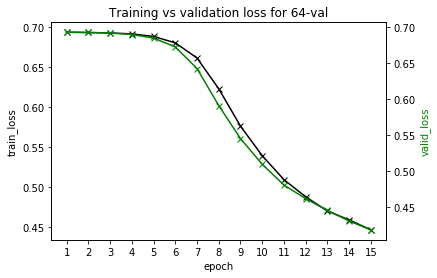

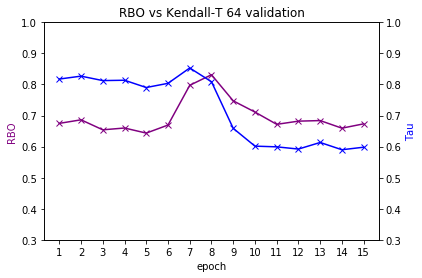

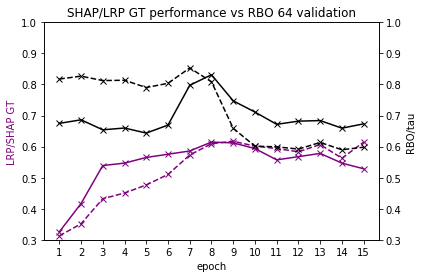

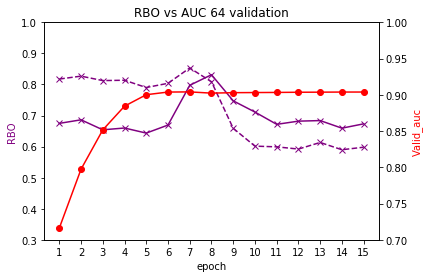

In [136]:
# Training vs validation loss
fig, ax = plt.subplots()
ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.train_loss,
    label="train",
    marker="x",
    color="black",
)
ax.set_xlabel("epoch")
ax.set_ylabel("train_loss", color='black')

ax2 = ax.twinx()
ax2.plot(
    [str(x+1) for x in training_df.index],
    training_df.valid_loss,
    label="valid",
    marker="x",
    color="green",
)
ax2.set_ylabel("valid_loss", color='green')
plt.title('Training vs validation loss for 64-val')

y_min = 0.3
# RBO vs Kendall Tau
fig, ax = plt.subplots()
ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_rbo,
    label="rbo",
    marker="x",
    color="purple",
)
ax.set_xlabel("epoch")
ax.set_ylabel("RBO", color='purple')
ax.set_ylim([y_min, 1.])

ax2 = ax.twinx()
ax2.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_tau,
    label="tau",
    marker="x",
    color="blue",
)
ax2.set_ylabel("Tau", color='blue')
ax2.set_ylim([y_min, 1.])
plt.title('RBO vs Kendall-T 64 validation')

# LRP GT vs SHAP vs RBO
fig, ax = plt.subplots()
ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.lrp_sim,
    label="rbo",
    marker="x",
    color="purple",
)

ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.shap_sim,
    label="shap",
    marker="x",
    color="purple",
    linestyle='--'
)
ax.set_xlabel("epoch")
ax.set_ylabel("LRP/SHAP GT", color='purple')
ax.set_ylim([y_min, 1.])

ax2 = ax.twinx()

ax2.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_rbo,
    label="rbo",
    marker="x",
    color="black",
)

ax2.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_tau,
    label="tau",
    marker="x",
    color="black",
    linestyle='--'
)
ax2.set_ylabel("RBO/tau", color='black')
ax2.set_ylim([y_min, 1.])
plt.title('SHAP/LRP GT performance vs RBO 64 validation')

# RBO vs valid AUC
fig, ax = plt.subplots()
ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_rbo,
    label="rbo",
    marker="x",
    color="purple",
)

ax.plot(
    [str(x+1) for x in training_df.index],
    training_df.svalid_tau,
    label="rbo",
    marker="x",
    color="purple",
    linestyle='--'
)
ax.set_ylim([y_min, 1.])
ax.set_xlabel("epoch")
ax.set_ylabel("RBO", color='purple')

ax2 = ax.twinx()
ax2.plot(
    [str(x+1) for x in training_df.index],
    training_df.valid_auc,
    label="auc",
    marker="o",
    color="red",
)
ax2.set_ylabel("Valid_auc", color='red')
ax2.set_ylim([0.7, 1.])
plt.title('RBO vs AUC 64 validation')


## 3. Extract scores from test set of 50

In [54]:
test_results = {}

for epoch in range(n_epochs):
    epoch_model_saved_path = lstm_model_save_path+"_epoch"+str(epoch)+".pkl"
    lstm_model.load_state_dict(torch.load(epoch_model_saved_path))
    lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())
    
    epoch_num = 'epoch_'+str(epoch)
    
    for (ids, labels, idxed_text) in test_dataloader:
        sel_idxes = [x for x in range(len(labels))]
        for sel_idx in sel_idxes:
            one_text = [
                int(token.numpy())
                for token in idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]

            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            # Record results        
            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if ids[sel_idx] not in test_results:
                test_results[ids[sel_idx]] = {}
            test_results[ids[sel_idx]][epoch_num] = {}
            test_results[ids[sel_idx]][epoch_num]['label'] = labels[sel_idx]
            test_results[ids[sel_idx]][epoch_num]['pred'] = lrp_model.s[0]
            test_results[ids[sel_idx]][epoch_num]['imp'] = df.copy()
    
    print(f"finished LRP for epoch {epoch}")
    (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
        lstm_model.cuda(),
        valid_dataloader,
        test_dataloader,
        seq_len,
        "",
        save_output=False,
        n_background=100,
        background_negative_only=True,
        n_test=test_nrows,
        test_positive_only=False,
        is_test_random=False,
    )
    
    for idx, pid in enumerate(patients):
        df = test_results[pid][epoch_num]['imp']
        assert len(df) == len(scores[idx])
        df['shap_scores'] = scores[idx]
        df = df[['idx', 'seq_idx', 'token', 'att_weights', 'lrp_scores', 'shap_scores']]
        test_results[pid][epoch_num]['imp'] = df.copy()
    print(f"finished SHAP for epoch {epoch}")

Test data similarity by epoch

In [57]:
epoch_nb = []
epoch_t_corr = []
epoch_rbo = []

test_loss_lst = []
test_auc_lst = []

for epoch in range(n_epochs):
    epoch_model_saved_path = lstm_model_save_path+"_epoch"+str(epoch)+".pkl"
    lstm_model.load_state_dict(torch.load(epoch_model_saved_path))
    
    test_loss, test_auc = epoch_val_lstm(lstm_model, test_dataloader, loss_function)
    test_loss_lst.append(test_loss)
    test_auc_lst.append(test_auc)
    
for pid in test_results.keys():
    for epoch_num in test_results[pid].keys():
        imp_df = test_results[pid][epoch_num]["imp"]
        imp_df["u_token"] = [
            str(seq) + "_" + str(token)
            for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
        ]

        test_results[pid][epoch_num]["t_corr"] = get_wtau(
            imp_df["lrp_scores"], imp_df["shap_scores"]
        )

        test_results[pid][epoch_num]["rbo"] = get_rbo(
            imp_df["lrp_scores"], imp_df["shap_scores"], imp_df["u_token"].tolist()
        )
        
        epoch_nb.append(epoch_num)
        epoch_t_corr.append(test_results[pid][epoch_num]["t_corr"])
        epoch_rbo.append(test_results[pid][epoch_num]["rbo"])
        

corr_df = pd.DataFrame()
corr_df['epoch'] = epoch_nb
corr_df['rbo'] = epoch_rbo
corr_df['tau_corr'] = epoch_t_corr


corr_df = corr_df.groupby('epoch').mean()        
corr_df['test_loss'] = test_loss_lst
corr_df['test_auc'] = test_auc_lst

Text(0, 0.5, 'Test_loss')

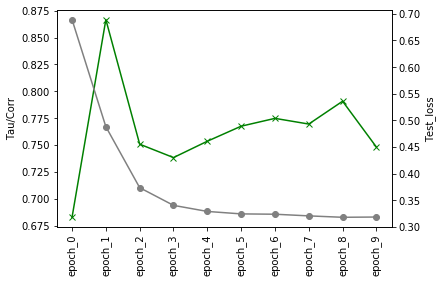

In [66]:
fig, ax = plt.subplots()
#ax.plot(corr_df.index, corr_df.tau_corr, label='tau_corr', marker='x', color='black')
ax.plot(corr_df.index, corr_df.rbo, label='rbo', marker='x', color='green')
ax.set_ylabel('Tau/Corr', color='green')
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(corr_df.index, corr_df.test_loss, marker='o', color='gray')
ax2.set_ylabel('Test_loss', color='gray')

In [49]:
example_results = {}

for epoch in range(n_epochs):
    epoch_model_saved_path = lstm_model_save_path+"_epoch"+str(epoch)+".pkl"
    lstm_model.load_state_dict(torch.load(epoch_model_saved_path))
    lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())
    
    epoch_num = 'epoch_'+str(epoch)
    
    for (ids, labels, idxed_text) in example_dataloader:
        sel_idxes = [x for x in range(len(labels))]
        for sel_idx in sel_idxes:
            one_text = [
                int(token.numpy())
                for token in idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]

            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            # Record results        
            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if ids[sel_idx] not in example_results:
                example_results[ids[sel_idx]] = {}
            example_results[ids[sel_idx]][epoch_num] = {}
            example_results[ids[sel_idx]][epoch_num]['label'] = labels[sel_idx]
            example_results[ids[sel_idx]][epoch_num]['pred'] = lrp_model.s[0]
            example_results[ids[sel_idx]][epoch_num]['imp'] = df.copy()
    
    print(f"finished LRP for epoch {epoch}")
    (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
        lstm_model.cuda(),
        valid_dataloader,
        example_dataloader,
        seq_len,
        "",
        save_output=False,
        n_background=100,
        background_negative_only=True,
        n_test=test_nrows,
        test_positive_only=False,
        is_test_random=False,
    )
    
    for idx, pid in enumerate(patients):
        df = example_results[pid][epoch_num]['imp']
        assert len(df) == len(scores[idx])
        df['shap_scores'] = scores[idx]
        df = df[['idx', 'seq_idx', 'token', 'att_weights', 'lrp_scores', 'shap_scores']]
        example_results[pid][epoch_num]['imp'] = df.copy()
    print(f"finished SHAP for epoch {epoch}")

finished LRP for epoch 0
finished SHAP for epoch 0
finished LRP for epoch 1
finished SHAP for epoch 1
finished LRP for epoch 2
finished SHAP for epoch 2
finished LRP for epoch 3
finished SHAP for epoch 3
finished LRP for epoch 4
finished SHAP for epoch 4
finished LRP for epoch 5
finished SHAP for epoch 5
finished LRP for epoch 6
finished SHAP for epoch 6
finished LRP for epoch 7
finished SHAP for epoch 7
finished LRP for epoch 8
finished SHAP for epoch 8
finished LRP for epoch 9
finished SHAP for epoch 9
finished LRP for epoch 10
finished SHAP for epoch 10
finished LRP for epoch 11
finished SHAP for epoch 11
finished LRP for epoch 12
finished SHAP for epoch 12
finished LRP for epoch 13
finished SHAP for epoch 13
finished LRP for epoch 14
finished SHAP for epoch 14


In [50]:
epoch_nb = []
epoch_t_corr = []
epoch_rbo = []

example_loss_lst = []
example_auc_lst = []

for epoch in range(n_epochs):
    epoch_model_saved_path = lstm_model_save_path+"_epoch"+str(epoch)+".pkl"
    lstm_model.load_state_dict(torch.load(epoch_model_saved_path))
    
    example_loss, example_auc = epoch_val_lstm(lstm_model, example_dataloader, loss_function)
    example_loss_lst.append(example_loss)
    example_auc_lst.append(example_auc)
    
for pid in example_results.keys():
    for epoch_num in example_results[pid].keys():
        imp_df = example_results[pid][epoch_num]["imp"]
        imp_df["u_token"] = [
            str(seq) + "_" + str(token)
            for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
        ]

        example_results[pid][epoch_num]["t_corr"] = get_wtau(
            imp_df["lrp_scores"], imp_df["shap_scores"]
        )

        example_results[pid][epoch_num]["rbo"] = get_rbo(
            imp_df["lrp_scores"], imp_df["shap_scores"], imp_df["u_token"].tolist()
        )
        
        epoch_nb.append(epoch_num)
        epoch_t_corr.append(example_results[pid][epoch_num]["t_corr"])
        epoch_rbo.append(example_results[pid][epoch_num]["rbo"])


## PLOT SHAP 
- n_dim=5
- n_layers=1

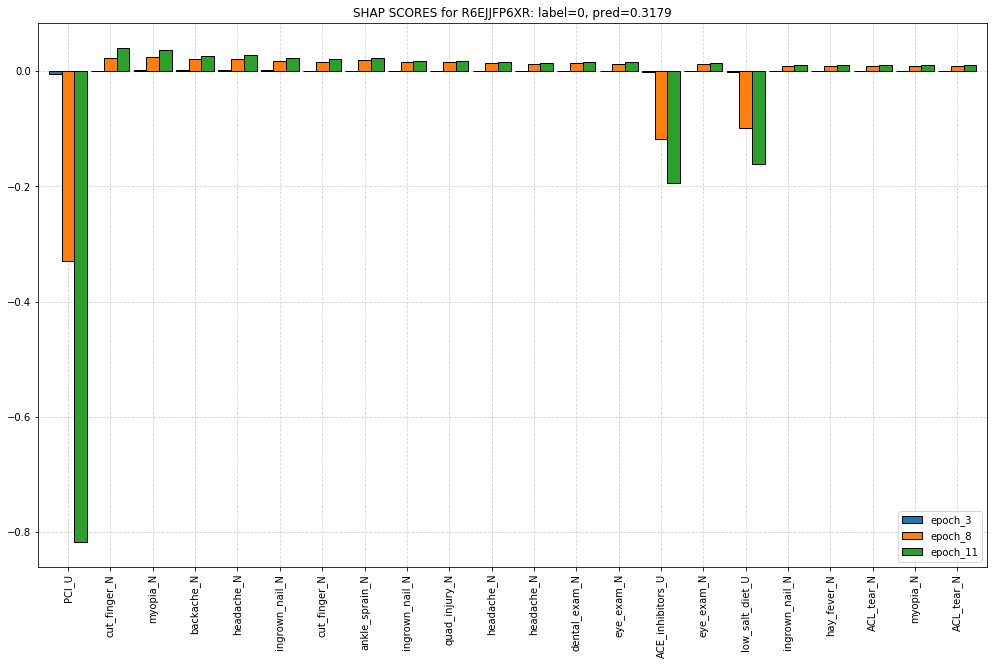

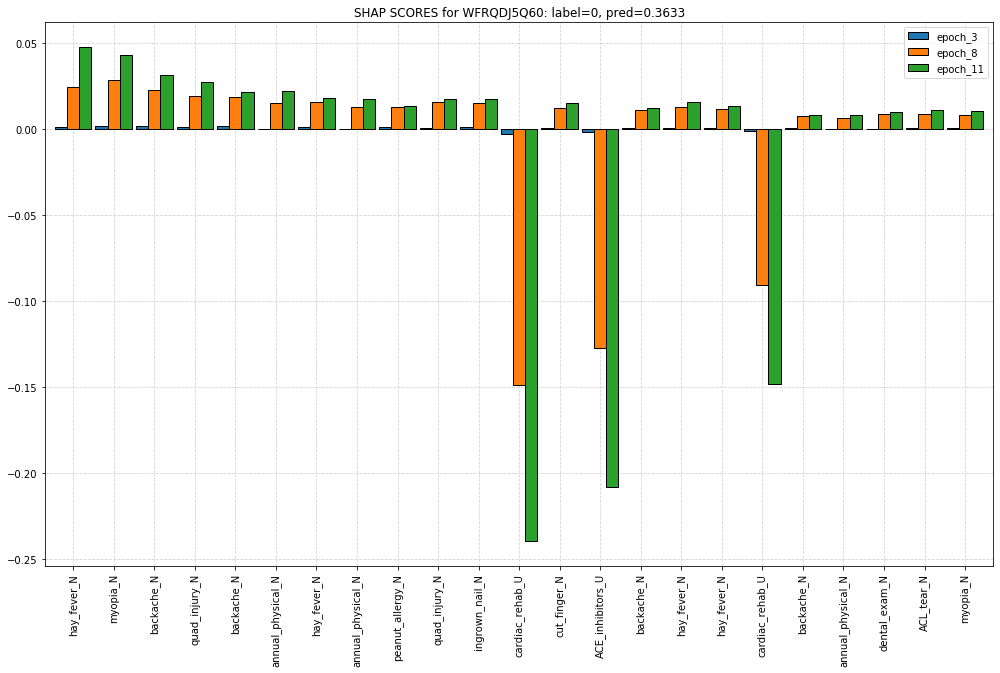

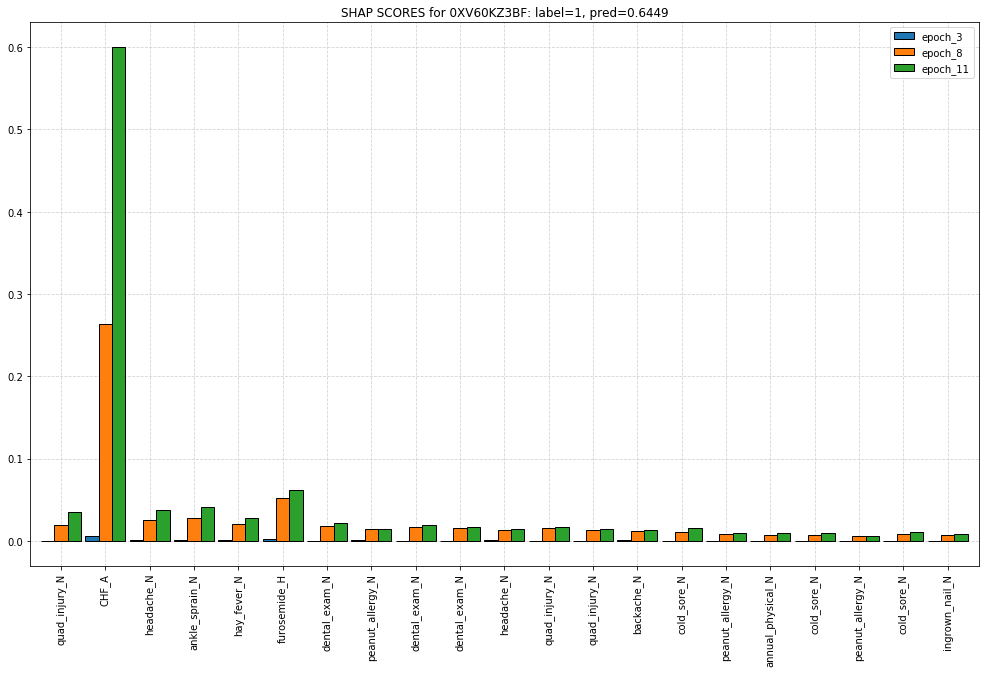

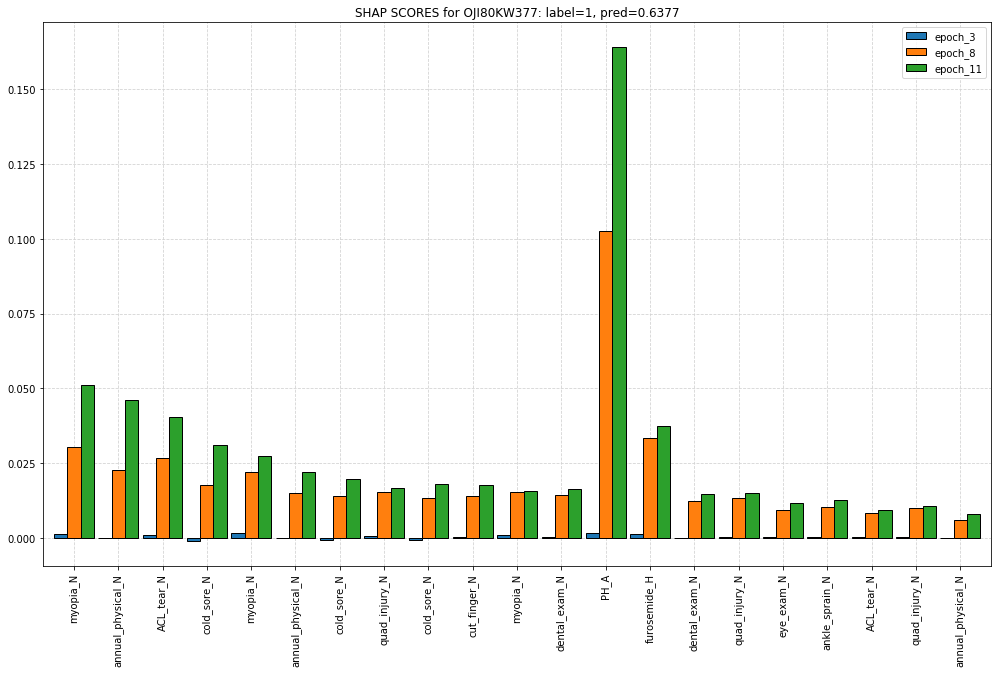

In [150]:
best_epoch='epoch_8'
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]['imp']['shap_scores']
    df['token'] = example_results[uid][epoch]['imp']['token']
    df['seq_idx'] = example_results[uid][epoch]['imp']['seq_idx']
    
    
    #df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[['epoch_3', 'epoch_8', 'epoch_11']].plot.bar(
        align='center', width=0.9, edgecolor='black', figsize=(17, 10))
    plt.xticks(df['seq_idx'], df.token.values.tolist(), rotation=90)
    
    lab = example_results[uid][best_epoch]['label']
    pred = np.round(torch.sigmoid(torch.tensor(example_results[uid][best_epoch]['pred'])).numpy(), 4)
    
    plt.title(f"SHAP SCORES for {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle='--')
    
    plt.show()

## PLOT LRP

In [138]:
plt.rcParams['axes.axisbelow'] = True

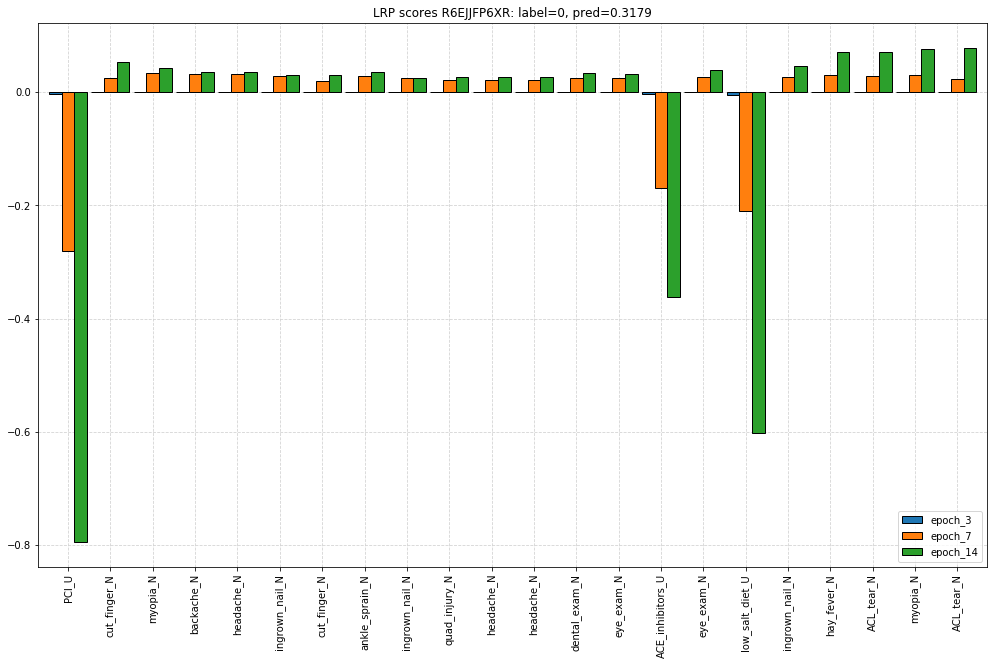

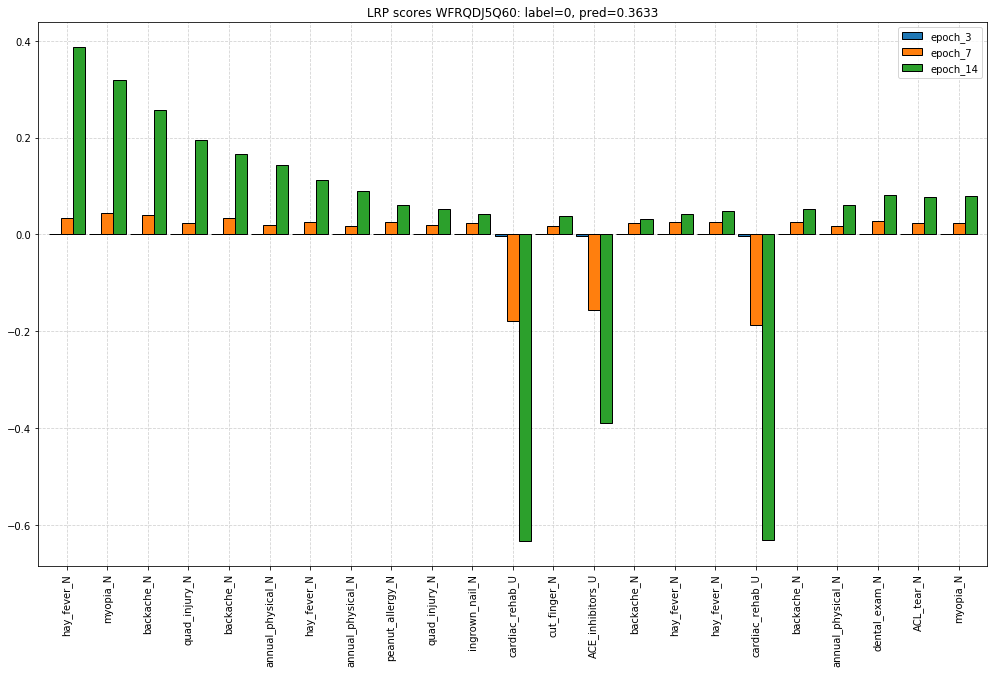

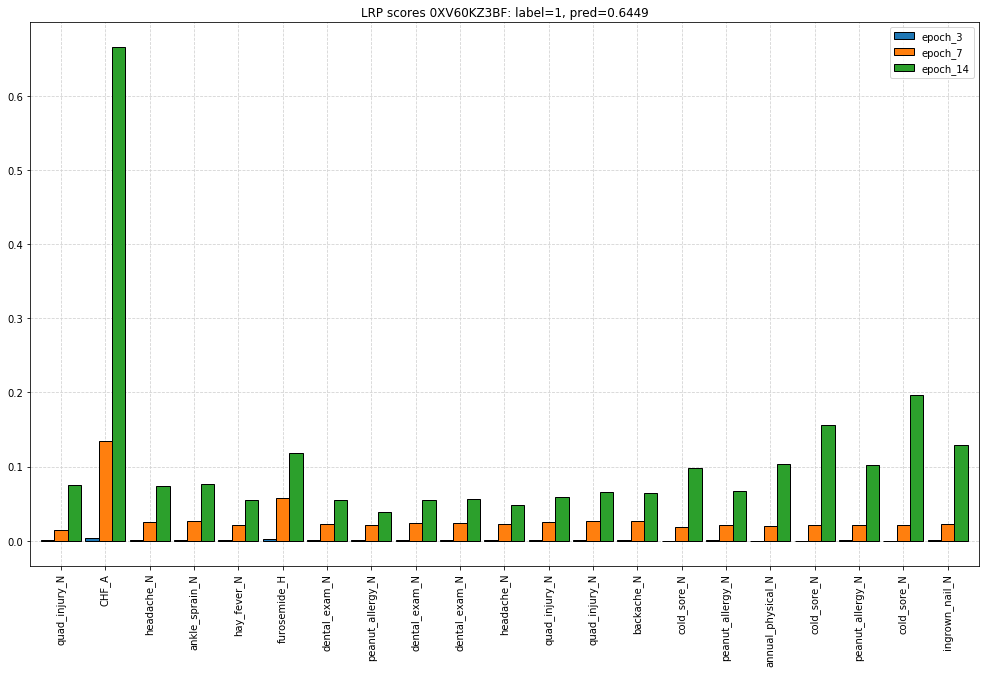

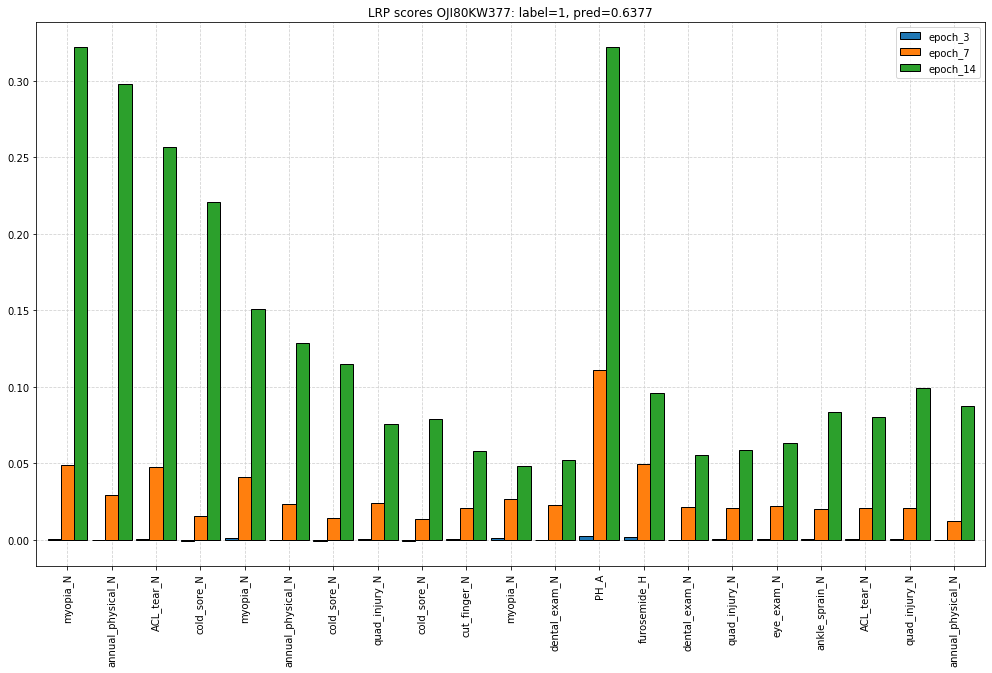

In [151]:
best_epoch = 'epoch_8'
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]['imp']['lrp_scores']
    df['token'] = example_results[uid][epoch]['imp']['token']
    df['seq_idx'] = example_results[uid][epoch]['imp']['seq_idx']
    
    #df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[['epoch_3', 'epoch_7', 'epoch_14']].plot.bar(
        align='center', width=0.9, edgecolor='black', figsize=(17, 10))
    plt.xticks(df['seq_idx'], df.token.values.tolist(), rotation=90, zorder=1)
    
    lab = example_results[uid][best_epoch]['label']
    pred = np.round(torch.sigmoid(torch.tensor(example_results[uid][best_epoch]['pred'])).numpy(), 4)
    
    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle='--',zorder=3)
    

## PLOT LSTM LRP & SHAP, LRP & SHAP & Attention scores separately

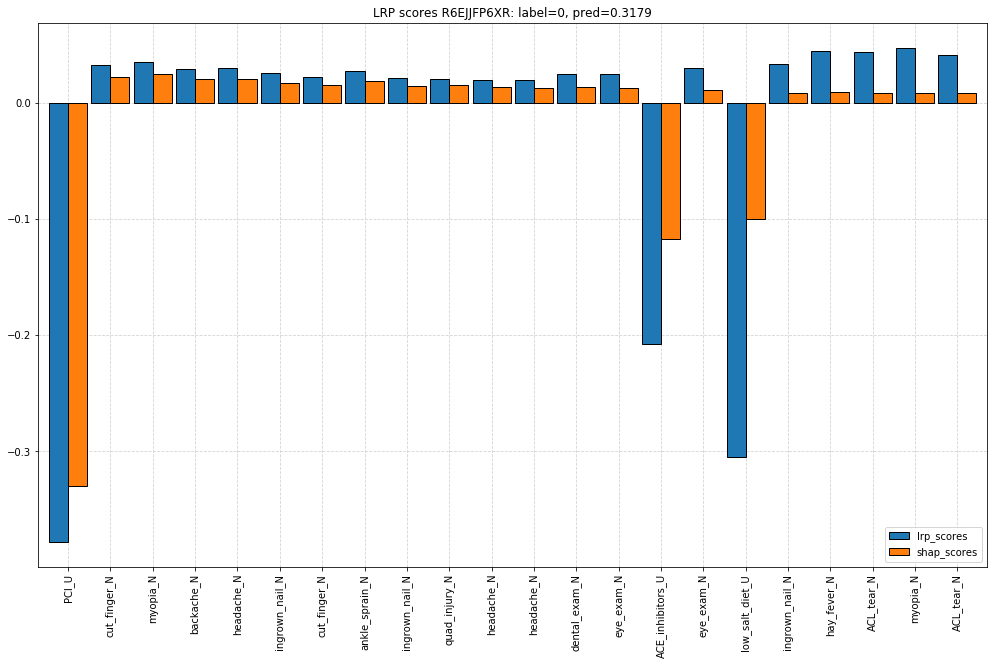

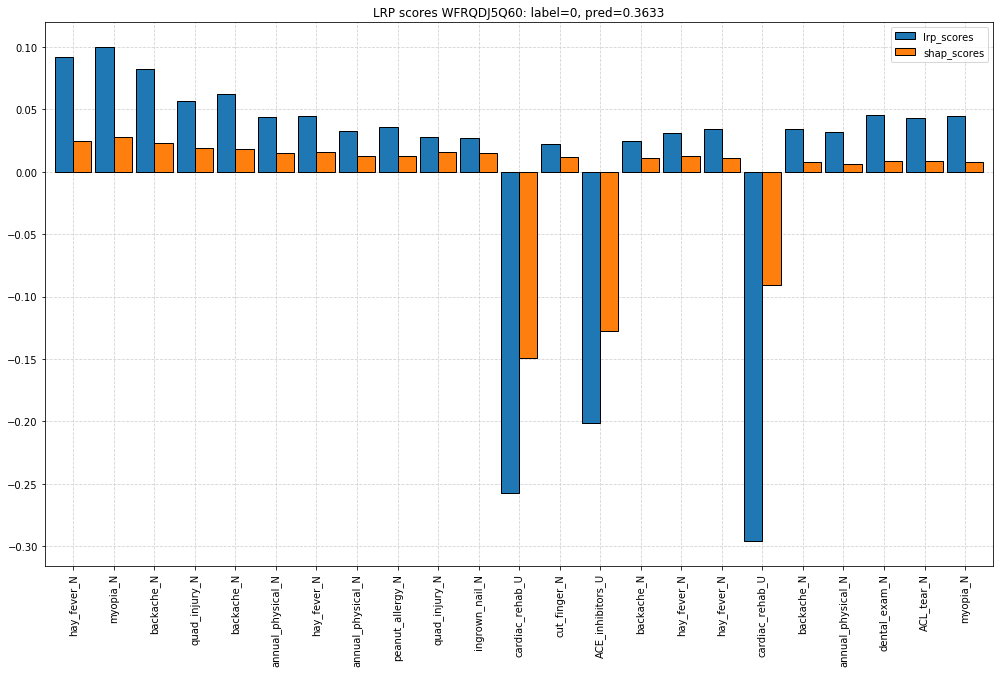

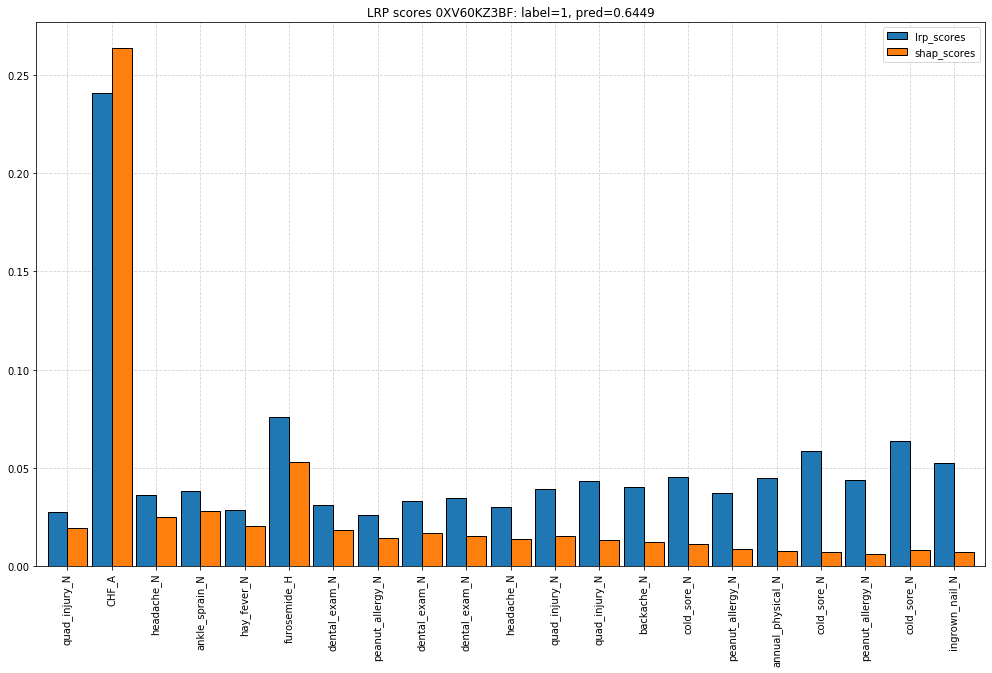

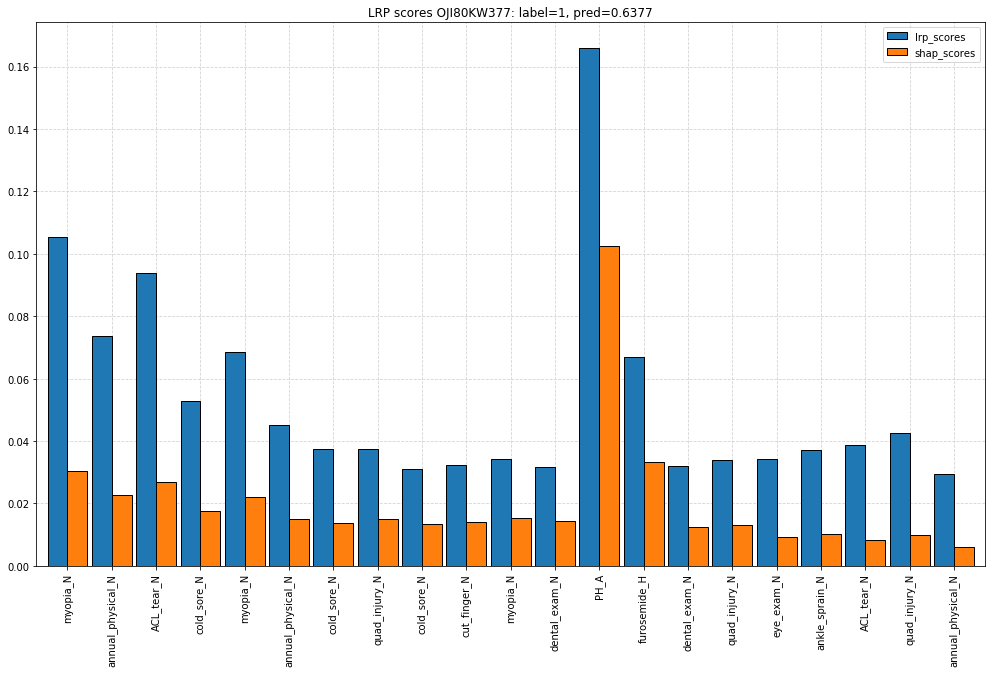

In [152]:
best_epoch = "epoch_8"
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    df[["lrp_scores", "shap_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

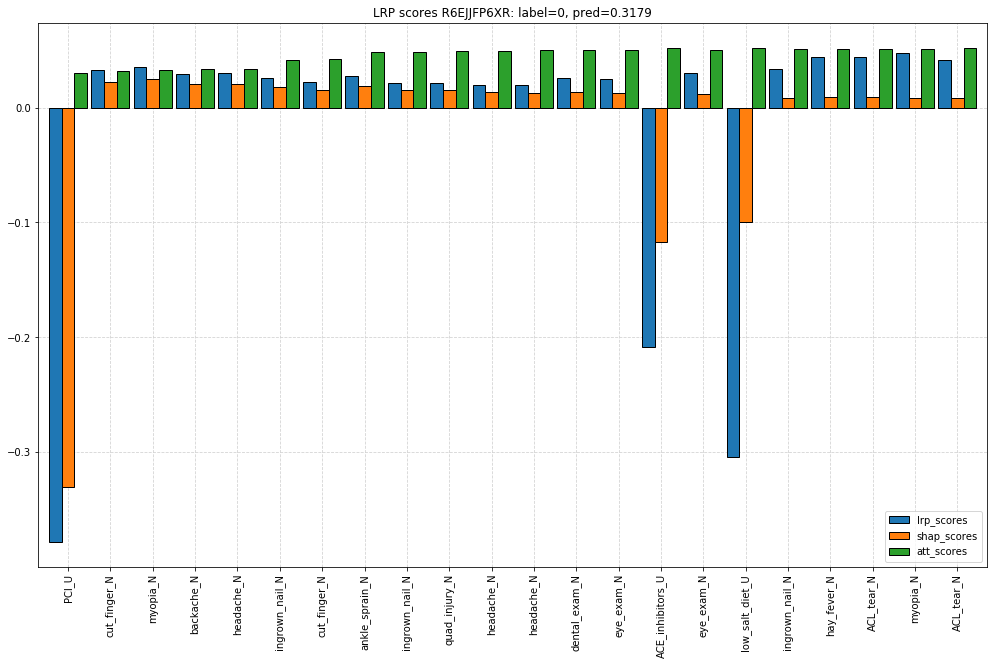

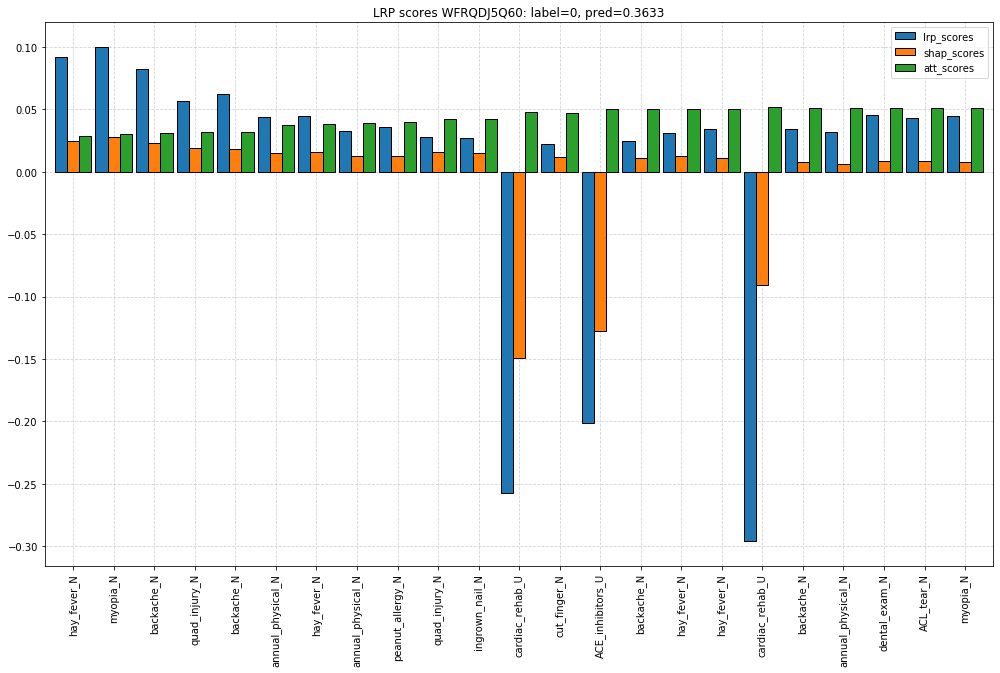

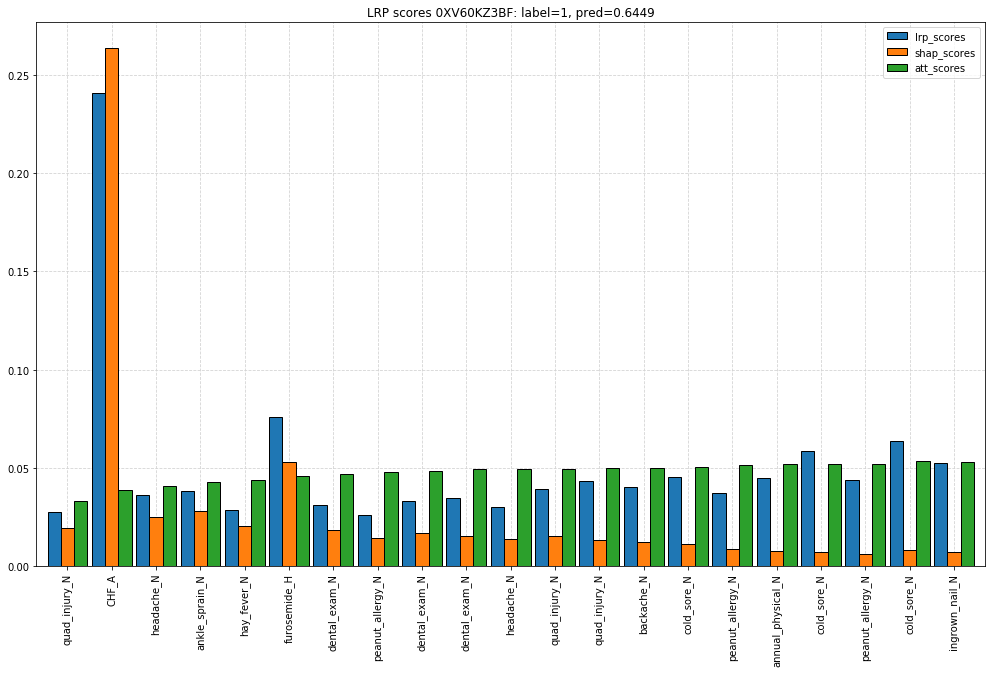

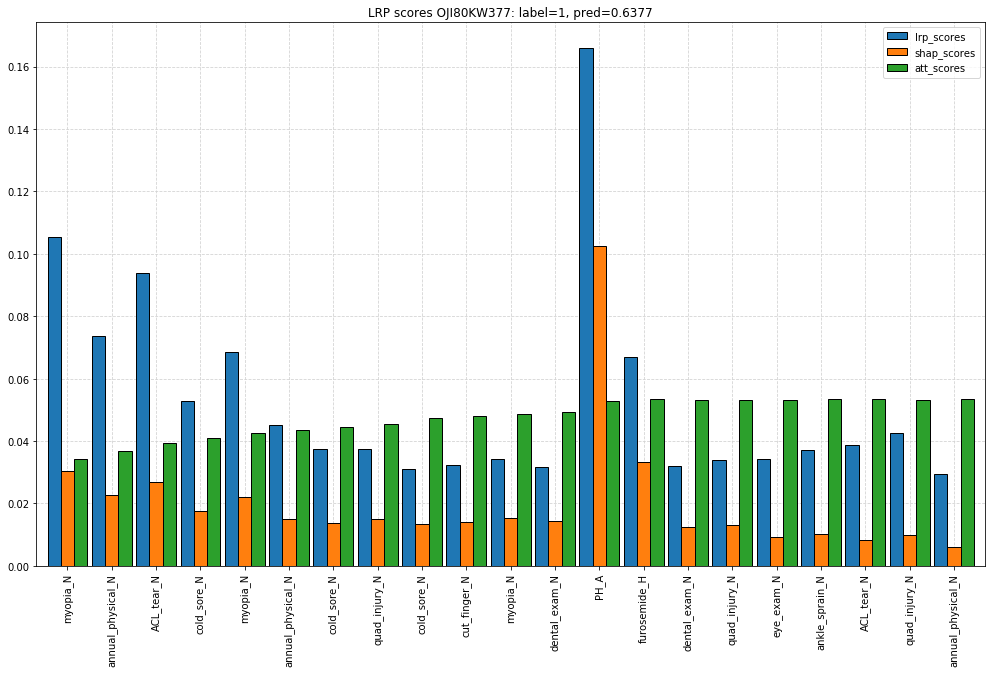

In [153]:
best_epoch = "epoch_8"
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]

    df[["lrp_scores", "shap_scores", "att_scores"]].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10)
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

## Determine which right RBO p to use

In [145]:
rbo_results = {}
for epoch in valid_results.keys():
    rbo_results[epoch] = []

    for p in range(1, 20, 1):
        p = p / 20.0

        rbo_val = []
        for pid in valid_results[epoch].keys():
            imp_df = valid_results[epoch][pid]["imp"]

            rbo_val.append(
                get_rbo(
                    imp_df["lrp_scores"],
                    imp_df["shap_scores"],
                    imp_df["u_token"].tolist(),
                    p=p,
                )
            )
        rbo_results[epoch].append((p, np.mean(rbo_val)))

Sensitivity curves

Text(0.5, 1.0, 'RBO vs epoch and p')

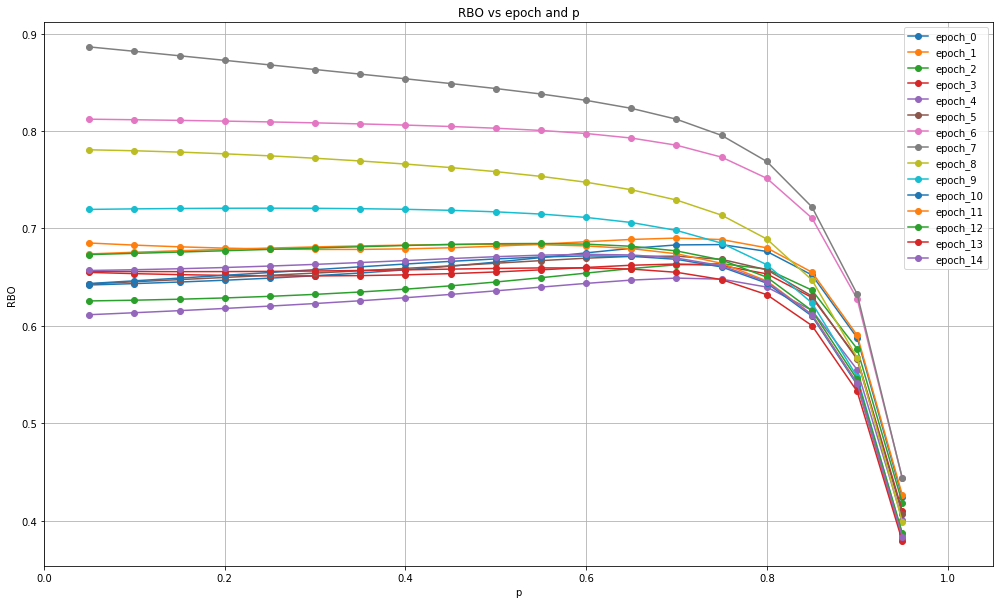

In [146]:
plt.figure(figsize=(17, 10))
for epoch in rbo_results.keys():
    results = rbo_results[epoch]
    plt.plot([r[0] for r in results], [r[1] for r in results], label='epoch_'+str(epoch), marker='o')
    
plt.ylabel('RBO')
plt.xlabel('p')
plt.legend()
plt.grid()
plt.xlim([0, 1.05])
plt.title("RBO vs epoch and p")

Text(0.5, 1.0, 'RBO vs epoch and p')

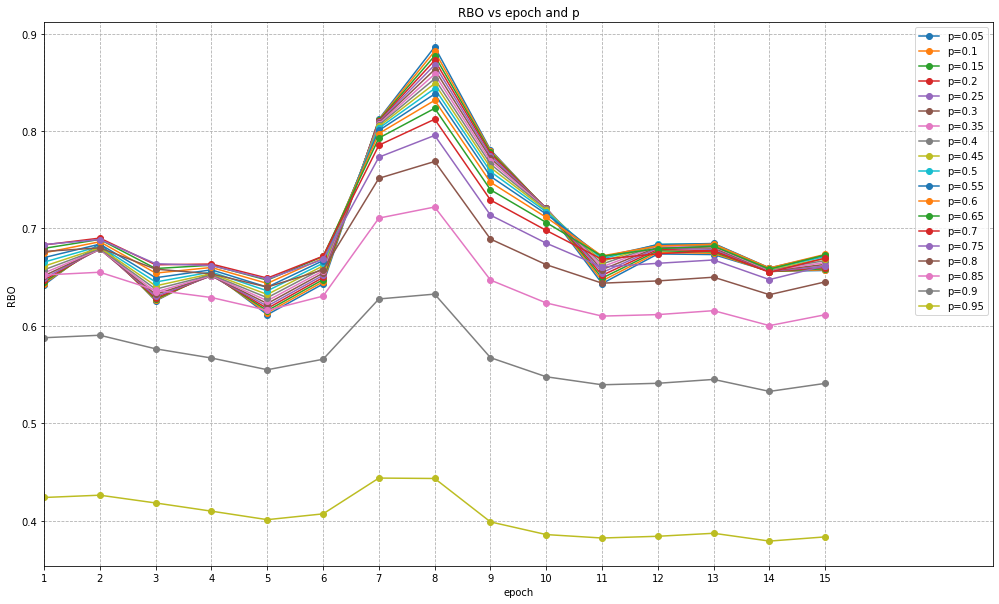

In [149]:
# reformat the data

plt.figure(figsize=(17, 10))
new_keys = [x[0] 
            for x in rbo_results[list(rbo_results.keys())[0]]]

melted_results={}
for key in new_keys:
    melted_results[key] = []
    
for epoch in rbo_results.keys():
    results = rbo_results[epoch]
    
    for key, val in results:
        melted_results[key].append((epoch, val))

for p in melted_results.keys():
    results = melted_results[p]
    plt.plot([str(r[0]+1) for r in results], [r[1] for r in results], label='p='+str(p), marker='o')
    
plt.ylabel('RBO')
plt.xlabel('epoch')
plt.xlim((0, 17))
plt.legend()
plt.grid(linestyle='--')
plt.title("RBO vs epoch and p")

Text(0.5, 1.0, 'Weighted Kendall Tau')

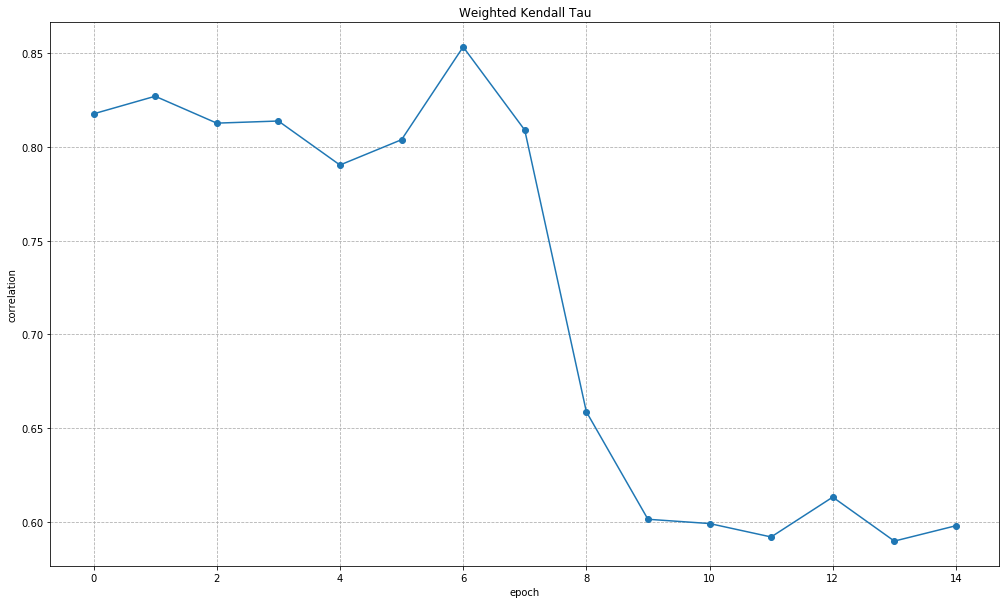

In [148]:
training_df['svalid_tau'].plot(marker='o', figsize=(17, 10))
plt.grid(linestyle='--')
plt.ylabel('correlation')
plt.title('Weighted Kendall Tau')

# UNDER CONSTRUCTION

## Calculate similarity, correlations

In [24]:
def get_sim(idx_model, idx_gt):
    return len(set(idx_model).intersection(set(idx_gt))) / len(idx_gt)

In [25]:
sim_pid = []
sim_shap = []
sim_lrp = []
sim_att = []

cor_shap_lrp = []
cor_att_lrp = []
cor_shap_att = []

n_token_lst = []
latt_lst = []
lattitude_pct = 0
tot_len_lst = []

for pid in test_results.keys():
    #if test_results[pid]["label"] >= 0 and test_results[pid]["pred"] > -999.:
        df = test_results[pid]["imp"]
        
        n_tokens = np.sum([True if '_H' in tok or '_A' in tok else False for tok in df.token])
        if n_tokens > 0:
            lattitude = int(np.max((int(np.floor(lattitude_pct * n_tokens)), 0)))

            idx_gt = [idx for idx, tok in enumerate(df.token) if '_H' in tok or '_A' in tok ]
            idx_shaps = np.argsort(df.shap_scores.values)[::-1][:n_tokens + lattitude]
            idx_lrp = np.argsort(df.lrp_scores.values)[::-1][:n_tokens + lattitude]
            idx_att = np.argsort(df.att_weights.values)[::-1][:n_tokens + lattitude]

            sim_pid.append(pid)
            sim_shap.append(get_sim(idx_shaps, idx_gt))
            sim_lrp.append(get_sim(idx_lrp, idx_gt))
            sim_att.append(get_sim(idx_att, idx_gt))

            df_corr = df.corr('spearman')
            cor_shap_lrp.append(df_corr.loc['shap_scores', 'lrp_scores'])
            cor_shap_att.append(df_corr.loc['shap_scores', 'att_weights'])
            cor_att_lrp.append(df_corr.loc['lrp_scores', 'att_weights'])

            n_token_lst.append(n_tokens)
            latt_lst.append(lattitude)
            tot_len_lst.append(df.shape[0])
        
sim_df = pd.DataFrame()
sim_df['pid'] = sim_pid
sim_df['gt_shap'] = sim_shap
sim_df['gt_lrp'] = sim_lrp
sim_df['gt_att'] = sim_att
sim_df['cor_shap_lrp'] = cor_shap_lrp
sim_df['cor_att_lrp'] = cor_att_lrp
sim_df['cor_shap_att'] = cor_shap_att
sim_df['n_tok'] = n_token_lst
sim_df['n_lat'] = latt_lst
sim_df['length'] = tot_len_lst

In [26]:
sim_df.mean()

gt_shap          0.944444
gt_lrp           1.000000
gt_att           0.166667
cor_shap_lrp     0.794244
cor_att_lrp     -0.234249
cor_shap_att    -0.219327
n_tok            1.555556
n_lat            0.000000
length          14.444444
dtype: float64

In [27]:
sim_df.sort_values(['gt_shap', 'gt_lrp', 'gt_att'], ascending=False)

,pid,gt_shap,gt_lrp,gt_att,cor_shap_lrp,cor_att_lrp,cor_shap_att,n_tok,n_lat,length
8,79MTJBSOFA,1.0,1.0,1.0,0.904762,-0.238095,-0.166667,1,0,8
2,JMCORDOOD0,1.0,1.0,0.5,0.979021,-0.391608,-0.391608,2,0,12
0,LAAYHHLFVL,1.0,1.0,0.0,0.801478,-0.562069,-0.880788,3,0,29
1,1TA0T97WJG,1.0,1.0,0.0,0.800000,0.600000,0.800000,1,0,4
3,02YKDANVHD,1.0,1.0,0.0,0.982418,-0.626374,-0.674725,1,0,14
5,5EP72LG7VG,1.0,1.0,0.0,1.000000,-1.000000,-1.000000,1,0,2
6,B1ZETQBTKC,1.0,1.0,0.0,0.814286,-0.377340,-0.725616,2,0,29
7,O2JMWTG8Q2,1.0,1.0,0.0,0.800000,0.600000,0.800000,1,0,4
4,S5X26DA7CW,0.5,1.0,0.0,0.066229,-0.112753,0.265463,2,0,28


Text(0.5, 1.0, 'correlation between models')

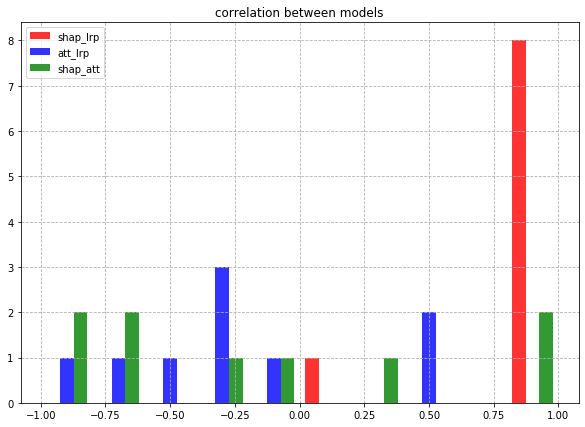

In [28]:
import seaborn as sns

plt.figure(figsize=(10, 7))
plt.grid('gray', linestyle='--')
plt.hist(
    sim_df[["cor_shap_lrp", "cor_att_lrp", "cor_shap_att"]].values,
    color=["r", "b", "g"],
    alpha=0.8,
    label=['shap_lrp', 'att_lrp', 'shap_att']
)
plt.legend()
plt.title('correlation between models')

Text(0.5, 1.0, 'Similarity to Ground Truth')

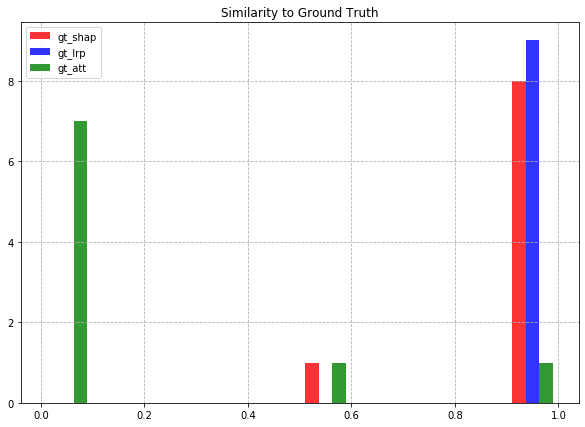

In [29]:
plt.figure(figsize=(10, 7))
plt.grid('gray', linestyle='--')
plt.hist(
    sim_df[["gt_shap", "gt_lrp", "gt_att"]].values,
    color=["r", "b", "g"],
    alpha=0.8,
    label=['gt_shap', 'gt_lrp', 'gt_att']
)
plt.legend()
plt.title('Similarity to Ground Truth')

## Plot examples

In [30]:
df.head()

,idx,seq_idx,token,att_weights,lrp_scores,shap_scores
0,18,0,ACL_tear_N,0.071454,0.230241,0.044158
1,16,1,hay_fever_N,0.107752,0.225571,0.039149
2,21,2,peanut_allergy_N,0.111869,0.226372,0.036254
3,2,3,backache_N,0.115444,0.130752,0.019815
4,16,4,hay_fever_N,0.118830,0.173885,0.026977


In [31]:
pid_lst = sim_df[sim_df.length > 0].sort_values(
    ['gt_shap', 'gt_lrp', 'gt_att'], ascending=True).pid[:10]

In [32]:
def normalize(z):
    return (z / z.max()).values

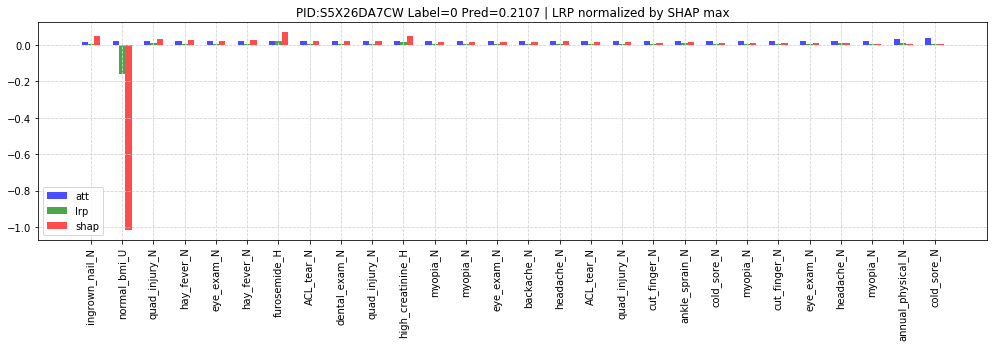

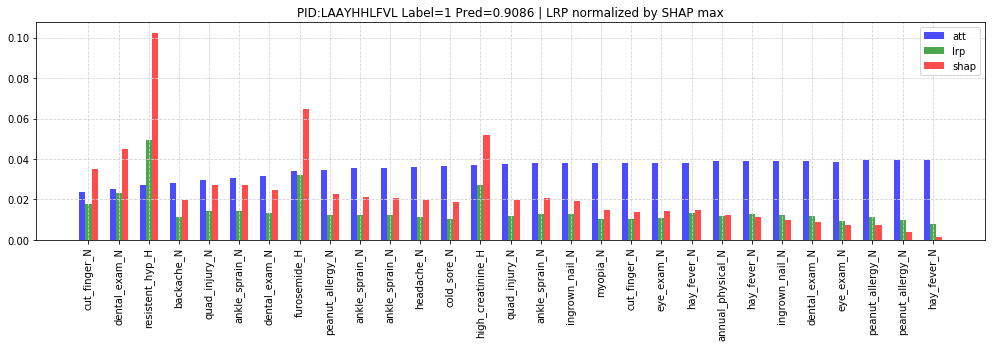

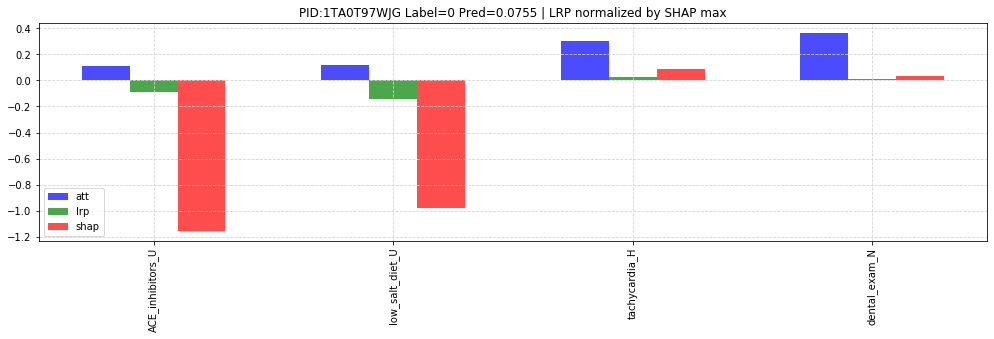

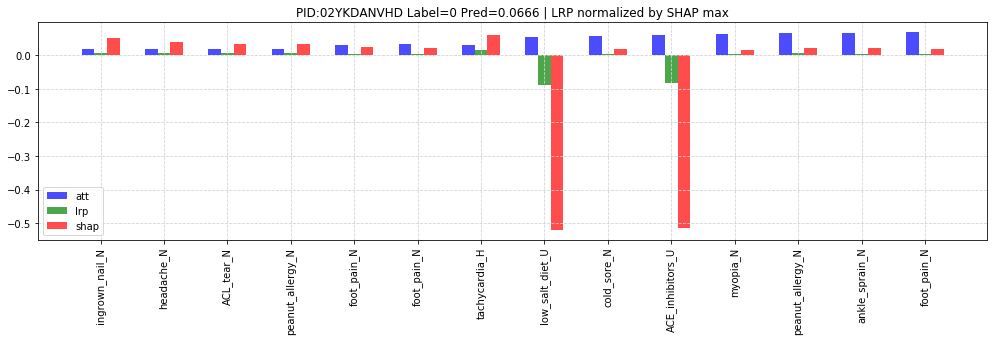

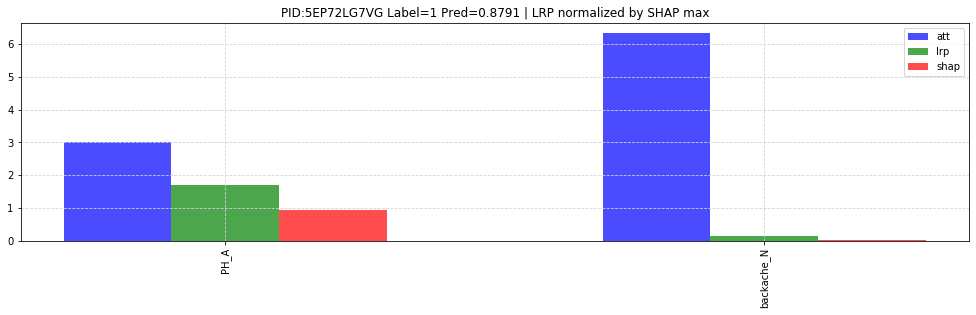

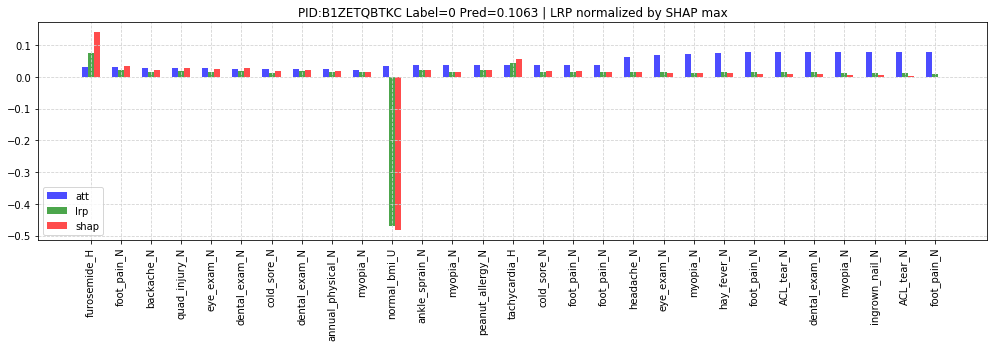

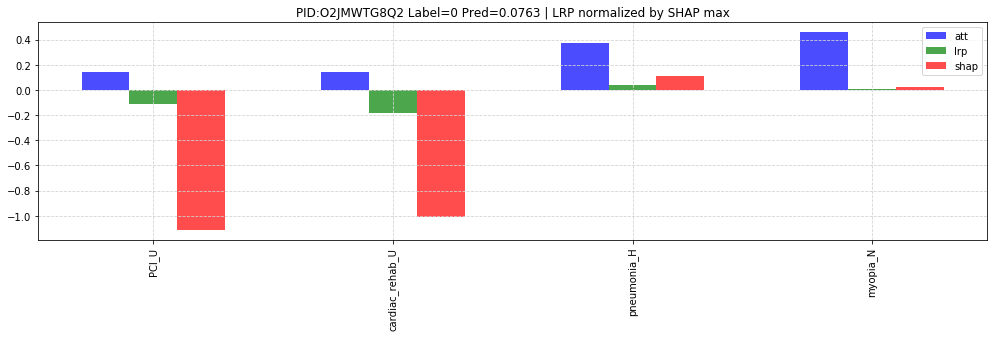

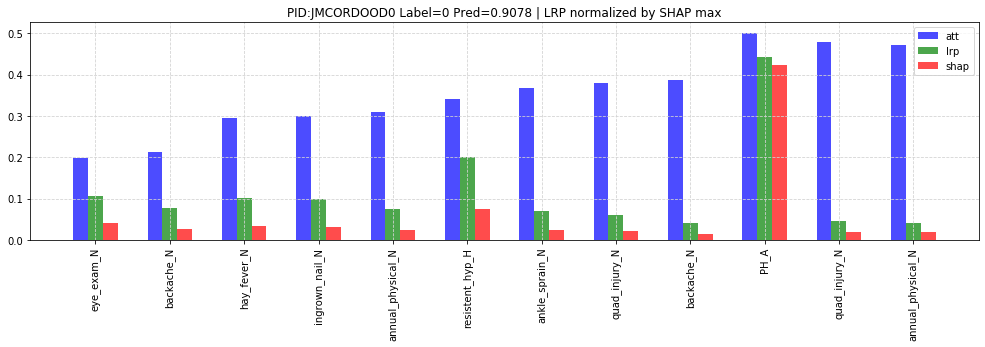

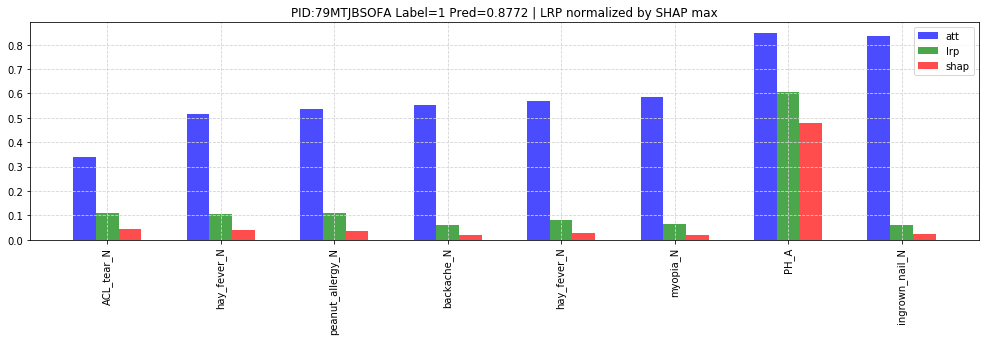

In [33]:
for pid in pid_lst: #pid = 'I4WOWX9EZF'
    lab = test_results[pid]['label']
    pred = np.round(torch.sigmoid(torch.tensor(test_results[pid]['pred'])).numpy(), 4)
    df = test_results[pid]['imp']
    x = df.seq_idx
    fig = plt.figure(figsize=(17, 4))
    ax = plt.subplot(111)
    plt.grid(color='lightgray', linestyle='--')
    ax.bar(x-0.2, df.att_weights * 10 * df.shap_scores.max(), width=0.2, color='b', align='center', alpha=0.7, label='att')
    ax.bar(x, df.lrp_scores * df.shap_scores.max(), width=0.2, color='g', align='center', alpha=0.7, label='lrp')
    ax.bar(x+0.2, df.shap_scores, width=0.2, color='r', align='center', alpha=0.7, label='shap')
    plt.xticks(x, df.token.values.tolist(), rotation=90)
    plt.legend()
    plt.title(f"PID:{pid} Label={lab[0]} Pred={pred:.4f} | LRP normalized by SHAP max")
    